<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/main/image_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup.

In [1]:
%%capture
!pip -q install rasterio
#!pip -q install torch
#!pip -q install torchvision
#!pip -q install albumentations
#!pip -q install segmentation-models-pytorch
#!pip -q install tqdm

In [39]:
import os
import re
#import torch
import rasterio
import rasterio.features
from rasterio.features import rasterize
from rasterio.enums import MergeAlg
import json
from shapely.geometry import LineString, Polygon
#import albumentations as A
#from torch.utils import data
#from torch.utils.data import Dataset, DataLoader
#import segmentation_models_pytorch as smp
#from torchvision import transforms as T
#from albumentations.pytorch import ToTensorV2
#import torch.nn as nn
#import torch.nn.functional as F
#import torchsummary
#from tqdm import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
#from PIL import Image
#import imageio
import numpy as np
#import cv2
from skimage.measure import label, regionprops
from sklearn.decomposition import PCA
import pandas as pd


# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Download  data to local compute node

## Mount your Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Compress files, copy over to compute node, and uncompress

In [4]:
# Navigate to the shared directory
#%cd /content/drive/MyDrive/Zindi-Amazon/
#!zip -r /content/predictions.zip WhateverDirectory
#!unzip /content/predictions.zip -d /content

# Description of process

Here's a method to identify clusters, fit lines to each one, and extract the endpoints and lengths. We'll start by identifying clusters, then fit lines to each, and finally calculate endpoints and filter based on length-to-width ratios.

**Step-by-Step Method:**
1.   **Identify Clusters:** We can identify clusters of connected pixels in the binary mask using connected component analysis. Each cluster corresponds to a connected component in the binary mask.
2.   **Fit a Line to Each Cluster:** For each identified cluster, fit a line using Principal Component Analysis (PCA), which will help determine the main axis of elongation for the cluster. The endpoints of the fitted line can be computed along this principal component.
3.   **Extract Lengths and Calculate Length/Width Ratios:** Once we have the principal component direction, calculate the length of the line by projecting the points onto the main axis. The width can be computed as the spread of points orthogonal to this main axis, allowing for length-to-width ratio calculations.
4.   **Reject bad clusters:** Airstrips are long and narrow. In the training set, the shortest LINESTRING was 376 meters. With a 20-meter buffer, the mininal lenght of the prediction shoud be over 400 meters. If we reject all clusters that do not intersect the bounding box, and are less than 300 meters long (30 pixels), we shoud remove almost all short road or dry river bed segments. For clusters that intersect the bounding box, we are not going to cut them based on the line segment lenght. If it looks like a problem, we'll devise a different cut.


In [5]:
def process_clusters(binary_mask, min_length=30, max_width=6):
    """
    Identifies and processes clusters (connected components) in the binary mask.
    """

    # Label connected components in the mask
    labeled_mask = label(binary_mask)
    clusters = regionprops(labeled_mask)
    image_height, image_width = binary_mask.shape  # Get image dimensions

    lines = []

    for cluster in clusters:
        # Check if the cluster has enough points for PCA
        if cluster.area < 2:  # At least 2 points needed for PCA
            # Handle clusters with insufficient points (e.g., skip, merge, etc.)
            print(f"Skipping cluster with {cluster.area} points - insufficient for PCA.")
            continue  # Skip this cluster

        # Extract the coordinates of the pixels in the cluster
        coords = cluster.coords

        # Perform PCA to find the main axis
        pca = PCA(n_components=2)
        pca.fit(coords)
        direction = pca.components_[0]
        variance = pca.explained_variance_

        # Compute the length of the cluster along the principal axis
        projected_coords = coords @ direction
        min_proj, max_proj = projected_coords.min(), projected_coords.max()
        length = max_proj - min_proj

        # Calculate width by projecting orthogonal to main axis
        # Using the max / min values we get a width that covers all
        # points, but could be impacted by outliers.
        # Using the standard deviation, we may be less susceptible to
        # outliers. Using 2 time the std, we cover 68% of all points. Using
        # 4 times the std would cover 95%. Something to test.
        orthogonal_direction = pca.components_[1]
        orthogonal_proj = coords @ orthogonal_direction
        width = orthogonal_proj.max() - orthogonal_proj.min()
        #width = 2.0 * np.std(orthogonal_proj)

        # Compute length-to-width ratio
        length_width_ratio = length / width if width != 0 else np.inf

        # Check if line touches the border:
        touches_border = any(
            (x == 0 or x == image_width - 1 or y == 0 or y == image_height - 1)
            for x, y in coords
        )


        # Filter based on length and border condition and width
        if (width <= max_width) and ((length >= min_length and not touches_border) or (touches_border)):
            # Get endpoints of the line along the main axis
            endpoint1 = pca.mean_ + direction * (min_proj - pca.mean_ @ direction)
            endpoint2 = pca.mean_ + direction * (max_proj - pca.mean_ @ direction)
            lines.append({
                "length": length,
                "width": width,
                "ratio": length_width_ratio,
                "endpoints": (endpoint1, endpoint2)
            })

    return lines

In [6]:
def plot_clusters_and_lines(binary_mask, lines):
    plt.figure(figsize=(20,20))  # Set figure size
    plt.imshow(binary_mask, cmap="gray")
    for line in lines:
        (x1, y1), (x2, y2) = line["endpoints"]
        plt.plot([y1, y2], [x1, x2], 'r-')
    plt.show()


In [7]:
def load_binary_mask_from_geotiff(geotiff_path):
    """
    Loads the binary mask from a GeoTIFF file and returns it as a NumPy array.
    """
    with rasterio.open(geotiff_path) as src:
        # Read the first band (assuming the binary mask is single-band and in the first band)
        binary_mask = src.read(1)

    # Ensure mask is binary (values should be 0 or 1)
    binary_mask = (binary_mask > 0).astype(np.uint8)

    return binary_mask


In [47]:
def lines_to_geojson(lines, geotiff_path, buffer_distance=200):
    """
    Converts lines with pixel coordinates to GeoJSON LINESTRING features
    using the GeoTIFF metadata, including the CRS.

    Args:
        lines: A list of line dictionaries, each with "endpoints" key.
        geotiff_path: Path to the GeoTIFF file.
        buffer_distance: Buffer distance in meters.

    Returns:
        A GeoJSON FeatureCollection containing the Polygon features with buffer.
    """

    with rasterio.open(geotiff_path) as src:
        transform = src.transform
        crs = src.crs

    features = []
    for line in lines:
        (x1, y1), (x2, y2) = line["endpoints"]

        # Convert pixel coordinates to geographic coordinates
        lon1, lat1 = rasterio.transform.xy(transform, x1, y1)
        lon2, lat2 = rasterio.transform.xy(transform, x2, y2)

        # Create Shapely LineString
        line_geom = LineString([(lon1, lat1), (lon2, lat2)])

        # Buffer the LineString (assuming UTM coordinates)
        polygon_geom_signal = line_geom.buffer(20)
        polygon_geom_buffer = line_geom.buffer(buffer_distance)

        # Create GeoJSON Polygon feature
        feature = {
            "type": "Feature",
            "geometry": polygon_geom_buffer.__geo_interface__,
            "properties": {
                "length": line["length"],
                "width": line["width"],
                "ratio": line["ratio"],
                "signal": 2
            }
        }
        features.append(feature)
        feature = {
            "type": "Feature",
            "geometry": polygon_geom_signal.__geo_interface__,
            "properties": {
                "length": line["length"],
                "width": line["width"],
                "ratio": line["ratio"],
                "signal": 1
            }
        }
        features.append(feature)

    # Create GeoJSON FeatureCollection with CRS
    geojson = {
        "type": "FeatureCollection",
        "features": features,
        "crs": {
            "type": "name",
            "properties": {
                "name": crs.to_string()  # Get CRS as a string
            }
        }
    }

    return geojson


In [55]:
def create_mask_from_geojson(geojson_data, geotiff_path, output_path):
    """
    Creates a new GeoTIFF mask from GeoJSON polygons,
    using the metadata of an existing GeoTIFF.

    Args:
        geojson_data: The GeoJSON data containing the polygons.
        geotiff_path: Path to the original GeoTIFF file.
        output_path: Path to save the new GeoTIFF mask.
    """

    with rasterio.open(geotiff_path) as src:
        # Get metadata from original GeoTIFF
        meta = src.meta.copy()

        # Update data type to uint8 for binary mask
        #meta.update(dtype=rasterio.uint8, count=1, nodata=None)
        meta.update(dtype=rasterio.uint8, count=1, nodata=0)

        # Create an empty mask array
        mask = np.zeros((meta['height'], meta['width']), dtype=rasterio.uint8)

        # Rasterize GeoJSON polygons onto the mask with value 1
        #for feature in geojson_data['features']:
        #    # Burn the polygon with a value of 1
        #    # Use rasterio.features.rasterize instead of features.rasterize
        #    rasterio.features.rasterize(
        #        [(feature['geometry'], 1)],
        #        out=mask,
        #        transform=meta['transform'],
        #        all_touched=True,
        #        #default_value=1,  # Set polygon value to 1
        #        default_value=np.uint8(feature['properties']['signal']),  # Set polygon value to 1
        #        dtype=rasterio.uint8,
        #    )

        # Prepare geometries with associated 'signal' values for rasterization
        shapes = [(feature['geometry'], feature['properties']['signal']) for feature in geojson_data['features']]

        # Rasterize the shapes with their respective 'signal' values
        rasterio.features.rasterize(
            shapes,
            out=mask,
            transform=meta['transform'],
            all_touched=True,
            dtype=rasterio.uint8,
            merge_alg=MergeAlg.replace  # Ensure each shape overwrites previous values
        )


        # Write the new mask to a GeoTIFF file
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(mask, indexes=1)


In [62]:
def create_dataframe_from_mask(mask_path, aoi_file):
    """
    Creates a Pandas DataFrame from a GeoTIFF mask file,
    extracting pixels with value 1.

    Args:
        mask_path: Path to the GeoTIFF mask file.
        aoi_file: Name of the AOI file (used in the DataFrame index).

    Returns:
        A Pandas DataFrame with columns 'pixel_id' and 'value'.
    """

    with rasterio.open(mask_path) as src:
        mask_data = src.read(1)  # Read the mask data as a NumPy array

    # Get indices of pixels with value 1 or 2
    row_indices, col_indices = np.where((mask_data == 1) | (mask_data == 2))

    # --- Overwrite label with 0 when mask_data is 2 ---
    labels = mask_data[row_indices, col_indices]  # Get original labels
    labels[labels == 2] = 0  # Overwrite 2 with 0

    # Create a list of pixel IDs in the specified format
    #
    # NOTICE THAT THE ZINDI TEAM FLIPPED THE COLUMN AND ROW!!!! THIS IS SO
    # WEIRD. MAKES NO SENSE TO BREAK WITH CONVENTIONS
    #
    #pixel_ids = [f'Tile{aoi_file}_{row}_{col}' for row, col in zip(row_indices, col_indices)]
    pixel_ids = [f'Tile{aoi_file}_{row}_{col}' for row, col in zip(col_indices, row_indices)]

    # Create the DataFrame
    df = pd.DataFrame({'tile_row_column': pixel_ids, 'label': labels})
    df.set_index('tile_row_column', inplace=True)

    return df

In [11]:
def export_dataframe_to_csv(df, csv_path):
    """
    Exports a Pandas DataFrame to a CSV file, appending if the file exists.

    Args:
        df: The Pandas DataFrame to export.
        csv_path: Path to the CSV file.
    """

    # Check if the file exists
    if os.path.exists(csv_path):
        # Append to the existing file without header
        df.to_csv(csv_path, mode='a', header=False, index=True)
    else:
        # Create a new file with header
        df.to_csv(csv_path, mode='w', header=True, index=True)


In [12]:
def extract_model_bands(text):
    """
    Extracts the part of the string after "lr0005".

    Args:
      text: The input string.

    Returns:
      The part of the string after "lr0005", or None if "lr0005" is not found.
    """
    match = re.search(r"lr0005_(.*)", text)
    if match:
        return match.group(1)
    else:
        return None


In [13]:
def modify_string_for_submission_file(input_string):
    """
    Removes "20" from the input string if it's in the format "aoi_20YY_MM".

    Args:
      input_string: The input string.

    Returns:
      The modified string with "20" removed, or the original string if
      it doesn't match the expected format.
    """
    return re.sub(r"aoi_20(\d\d)_(\d\d)", r"aoi_\1_\2", input_string)


# Main loop

This is where we load the GeoTIFF file prediction, find the clusters,
clean the image and then produce a final prediction. Notice that the final prediction must have a 200 meter buffer.

Processing aoi_2020_01


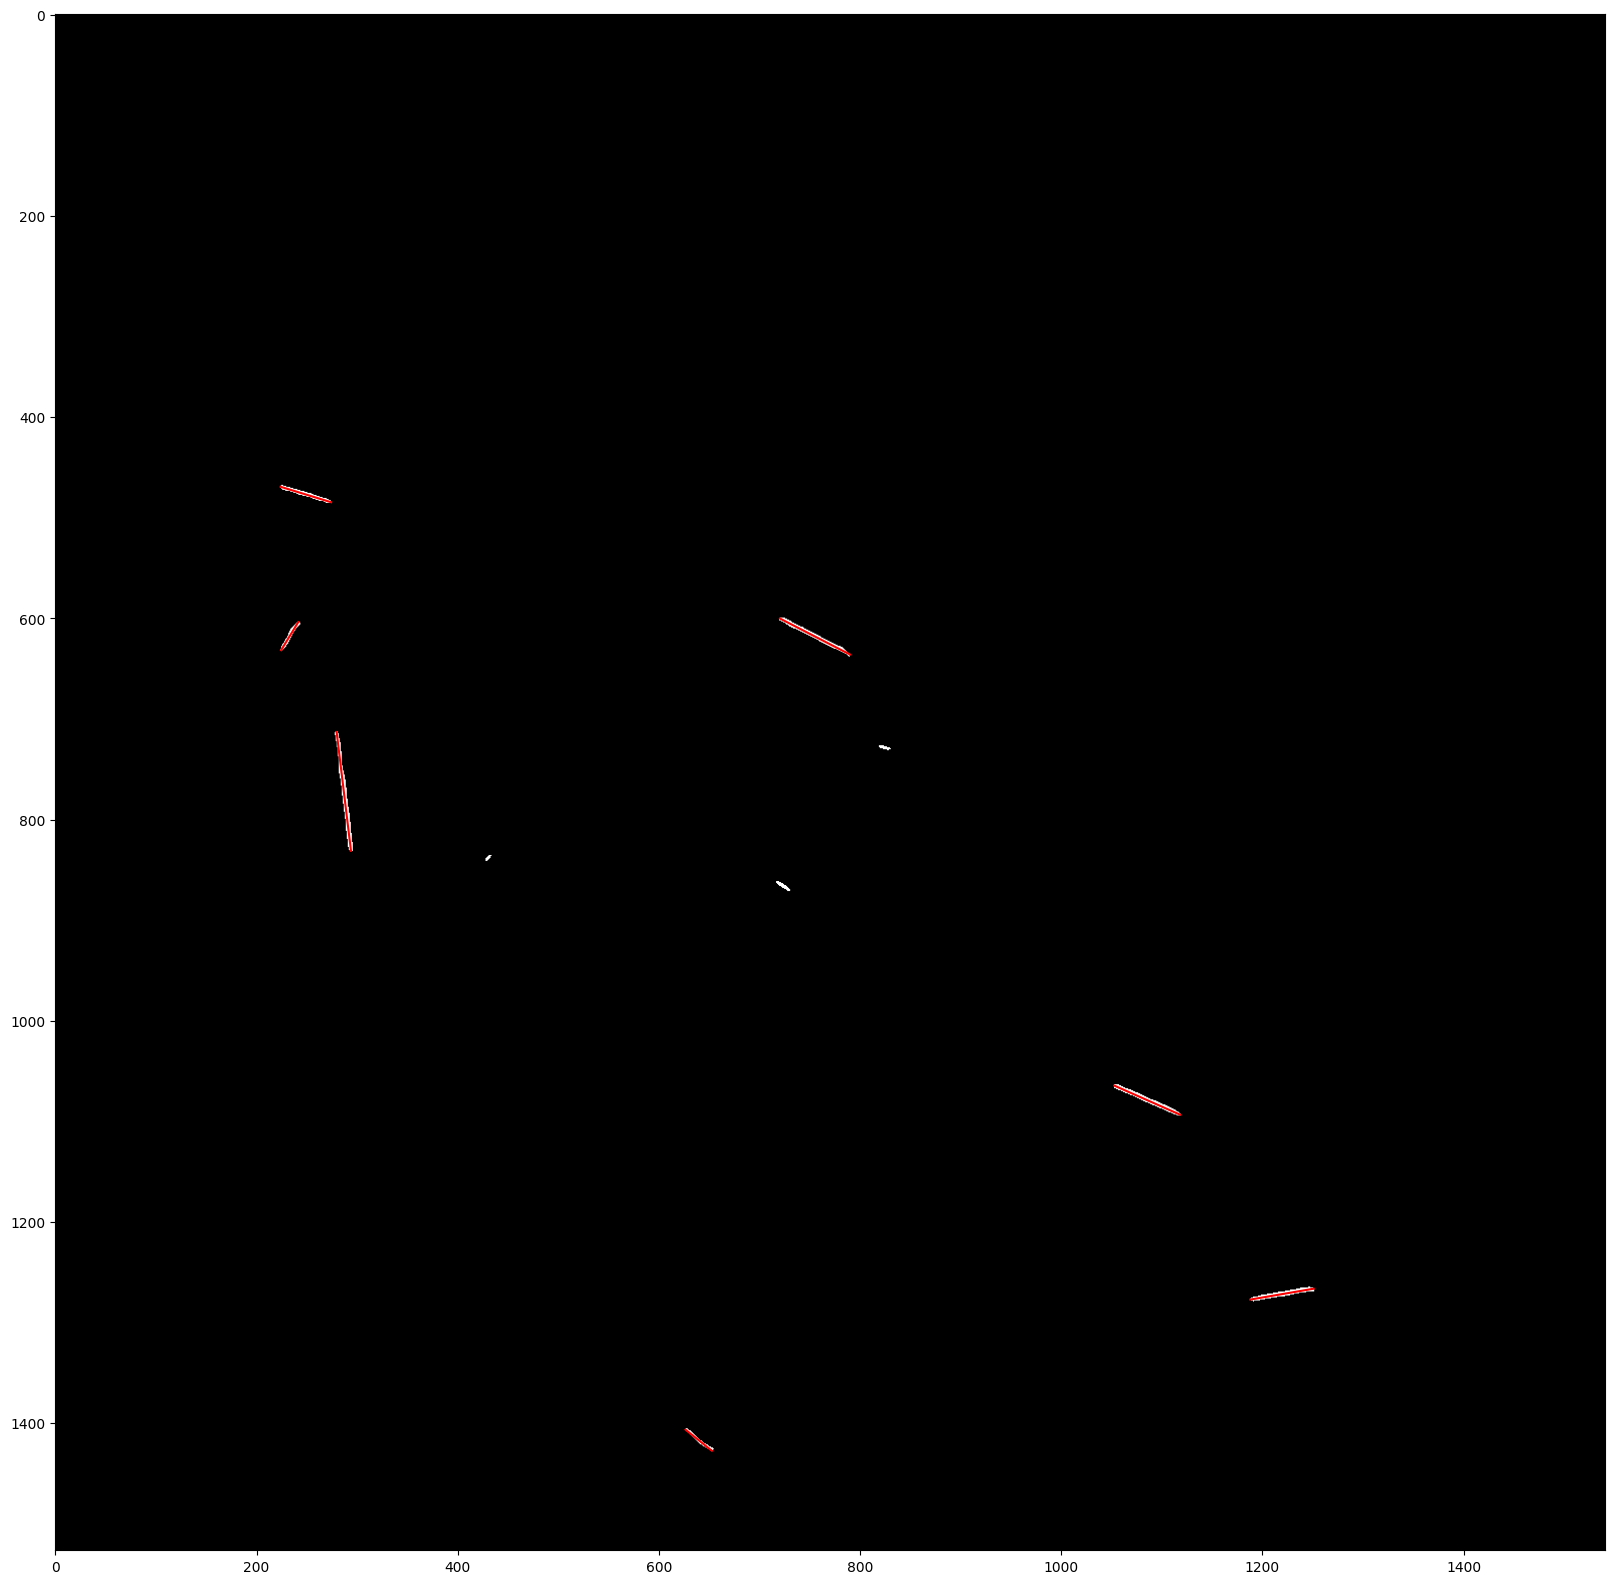

 Length: 52.4933570374659, Width: 4.467611560618593, Ratio: 11.749758528737798
 Endpoints: (array([469.18647054, 223.94293833]), array([484.54681969, 274.13867727]))
 Length: 78.28251799162513, Width: 5.098101911654254, Ratio: 15.355228151220633
 Endpoints: (array([600.17123423, 720.42605445]), array([635.96243026, 790.0474801 ]))
 Length: 32.75666729898762, Width: 5.090729621728769, Ratio: 6.434572199468675
 Endpoints: (array([603.69294833, 241.49521803]), array([631.67874008, 224.47186018]))
 Length: 119.06721466007866, Width: 5.150369131272129, Ratio: 23.118190487963986
 Endpoints: (array([712.92376937, 279.63098534]), array([831.13145577, 293.91189854]))
 Length: 71.57973004536302, Width: 4.9971247363985185, Ratio: 14.324183169570288
 Endpoints: (array([1064.50881152, 1052.77507949]), array([1093.44917254, 1118.24349369]))
 Length: 63.783700787482985, Width: 5.178550924983028, Ratio: 12.31690133233401
 Endpoints: (array([1277.24573199, 1188.0421699 ]), array([1266.45755745, 1250.90

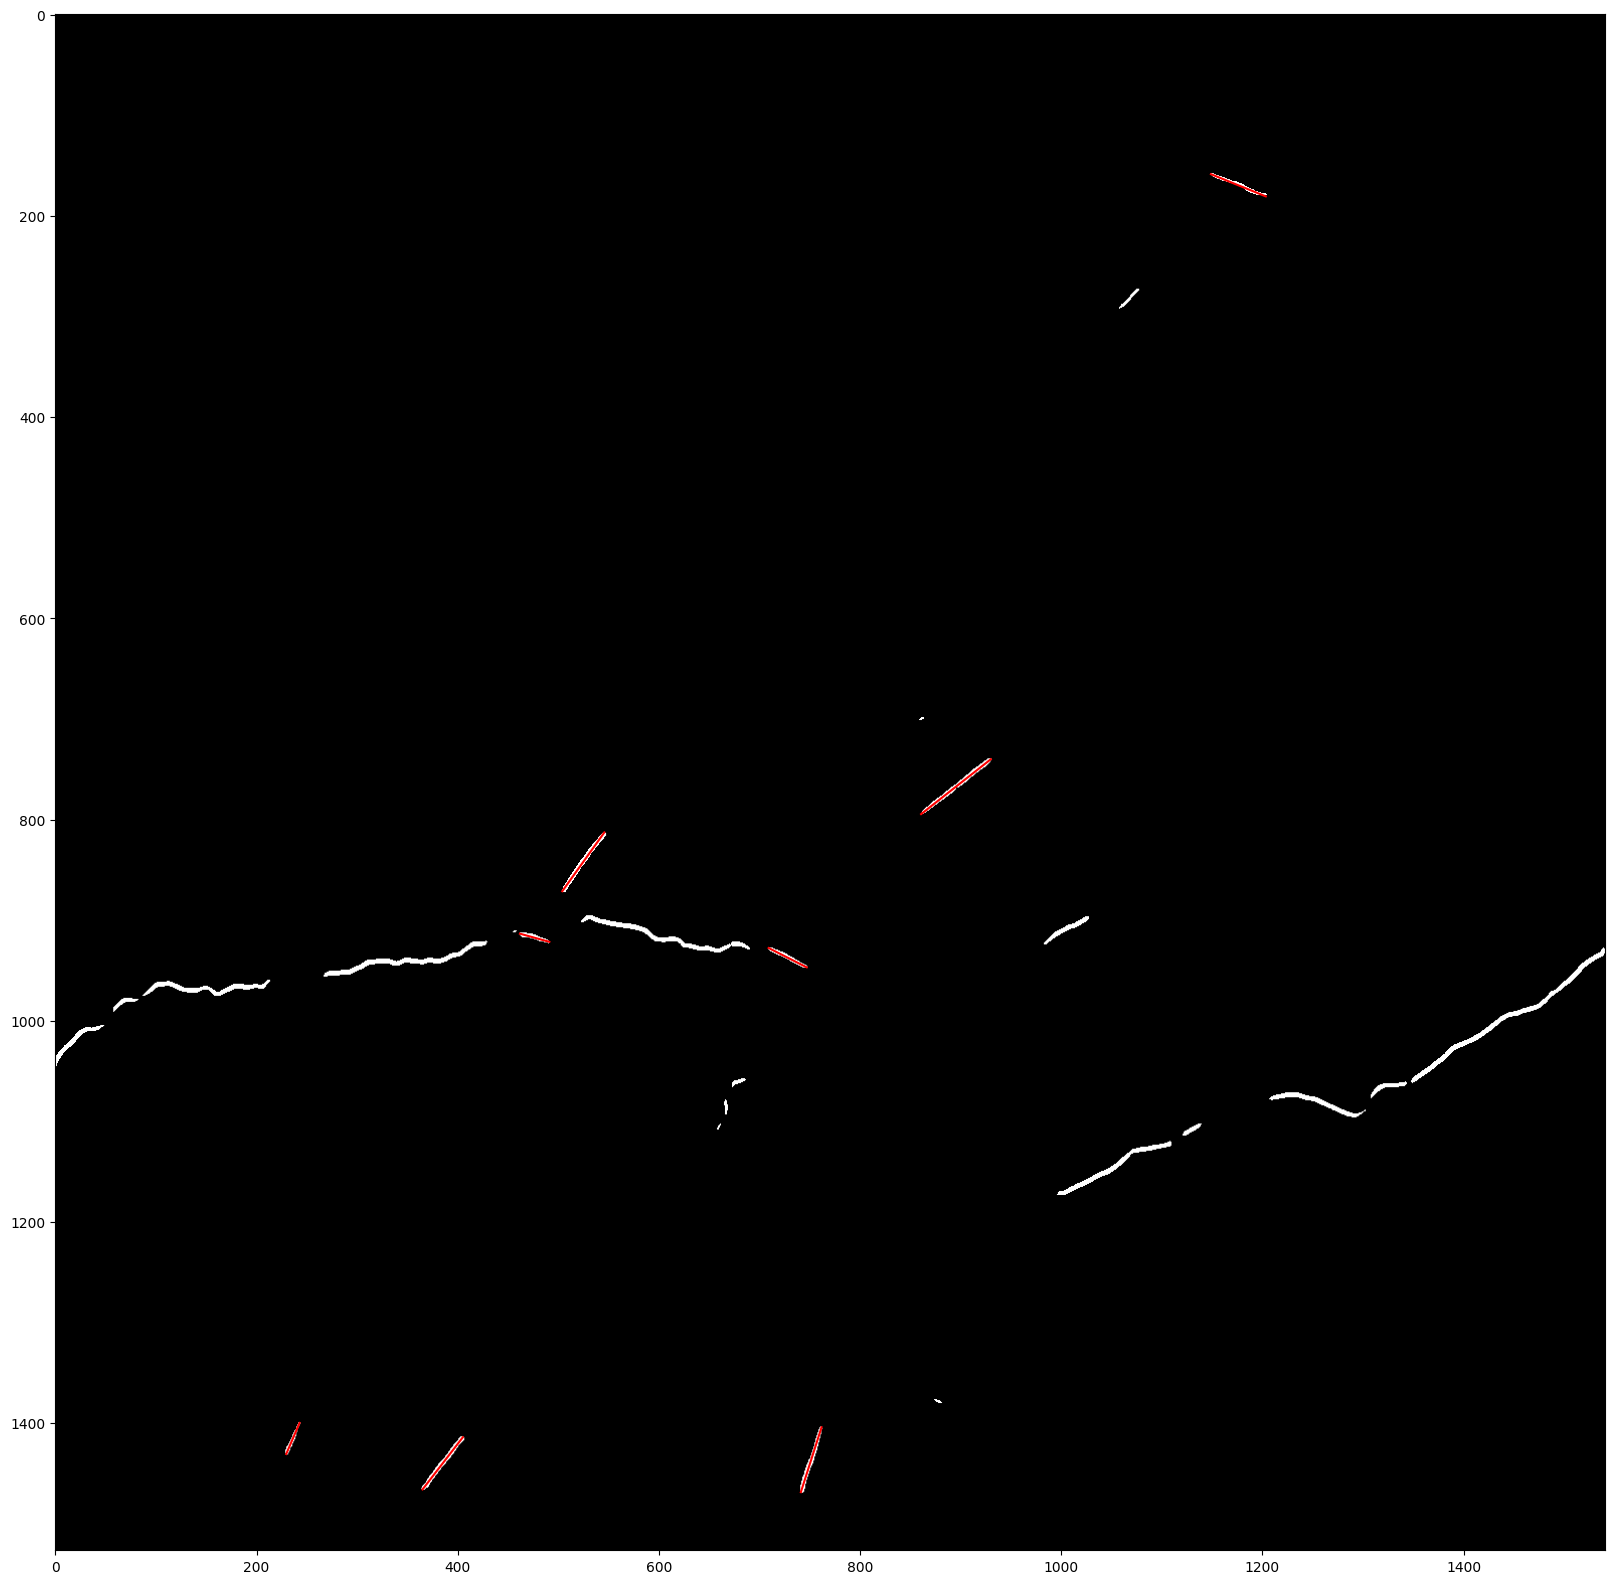

 Length: 58.86105613782797, Width: 4.965121168574399, Ratio: 11.854908297178243
 Endpoints: (array([ 158.37613266, 1148.84773098]), array([ 180.46347212, 1203.40754554]))
 Length: 88.23660450242164, Width: 5.268426753868198, Ratio: 16.748188524712113
 Endpoints: (array([794.61783952, 860.69925011]), array([740.04942531, 930.03889638]))
 Length: 71.84027012800692, Width: 5.903495861405759, Ratio: 12.169106545439348
 Endpoints: (array([812.84445415, 545.78260542]), array([871.26970863, 503.97932744]))
 Length: 30.350595444233704, Width: 5.564877883007966, Ratio: 5.453955339596489
 Endpoints: (array([913.47453535, 461.86830698]), array([921.59068527, 491.113593  ]))
 Length: 42.48446732932598, Width: 4.569549124065986, Ratio: 9.297299618813001
 Endpoints: (array([927.71808775, 709.14315808]), array([946.95404955, 747.02333414]))
 Length: 33.614154772393704, Width: 4.1987920592583805, Ratio: 8.00567265489467
 Endpoints: (array([1399.91443917,  242.80093149]), array([1430.79690168,  229.527

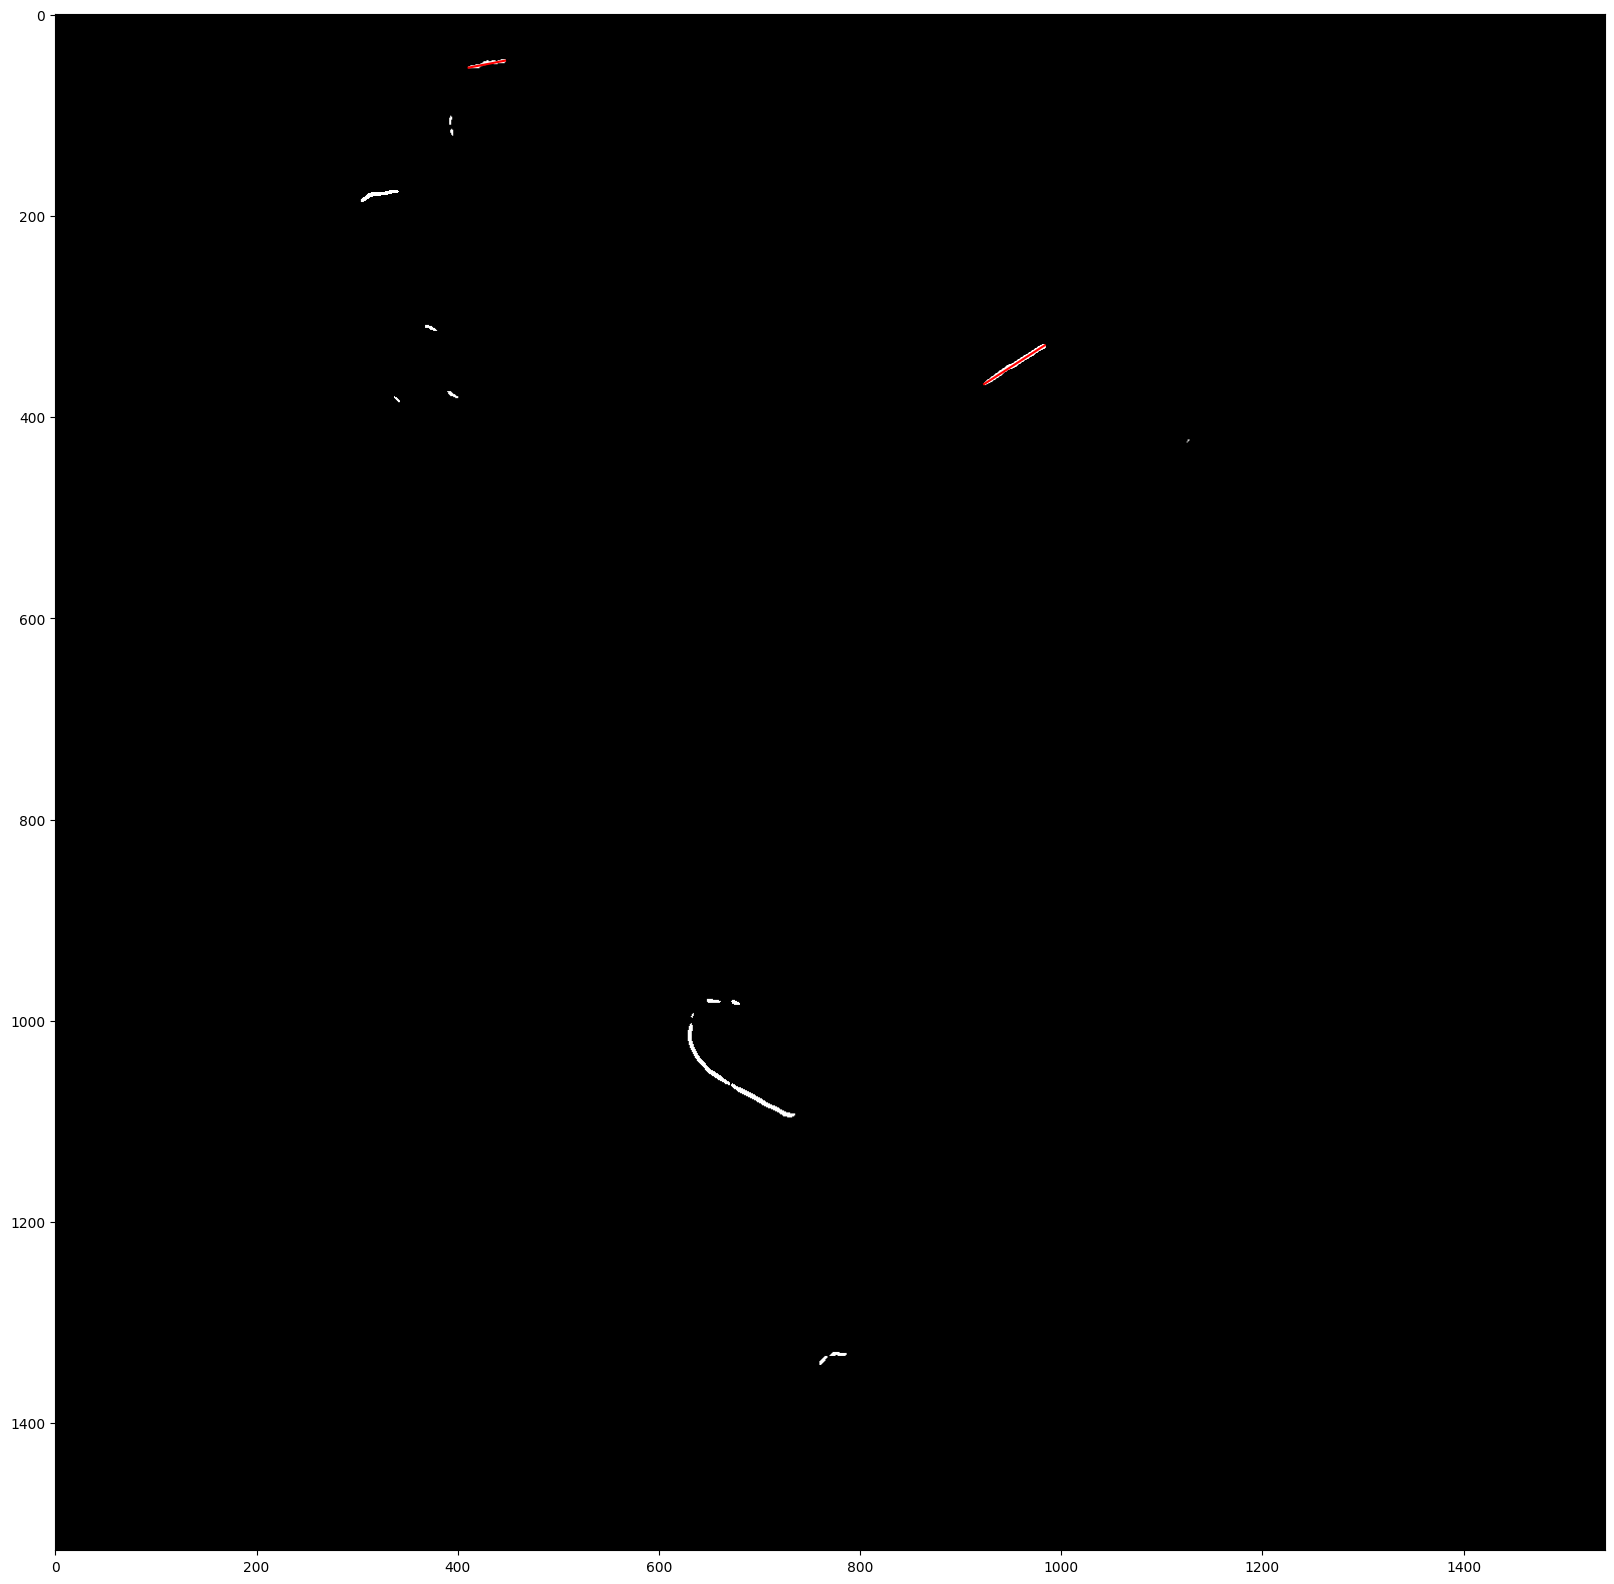

 Length: 36.863095983885046, Width: 5.362529480910823, Ratio: 6.874199221674744
 Endpoints: (array([ 52.46229578, 410.8965506 ]), array([ 45.49789138, 447.09578977]))
 Length: 71.55888509633758, Width: 5.687300265199042, Ratio: 12.582223860099496
 Endpoints: (array([367.04494267, 923.38999615]), array([328.52610448, 983.6973186 ]))
Number of pixels with background or signal:7137
Processing aoi_2021_01
Skipping cluster with 1.0 points - insufficient for PCA.


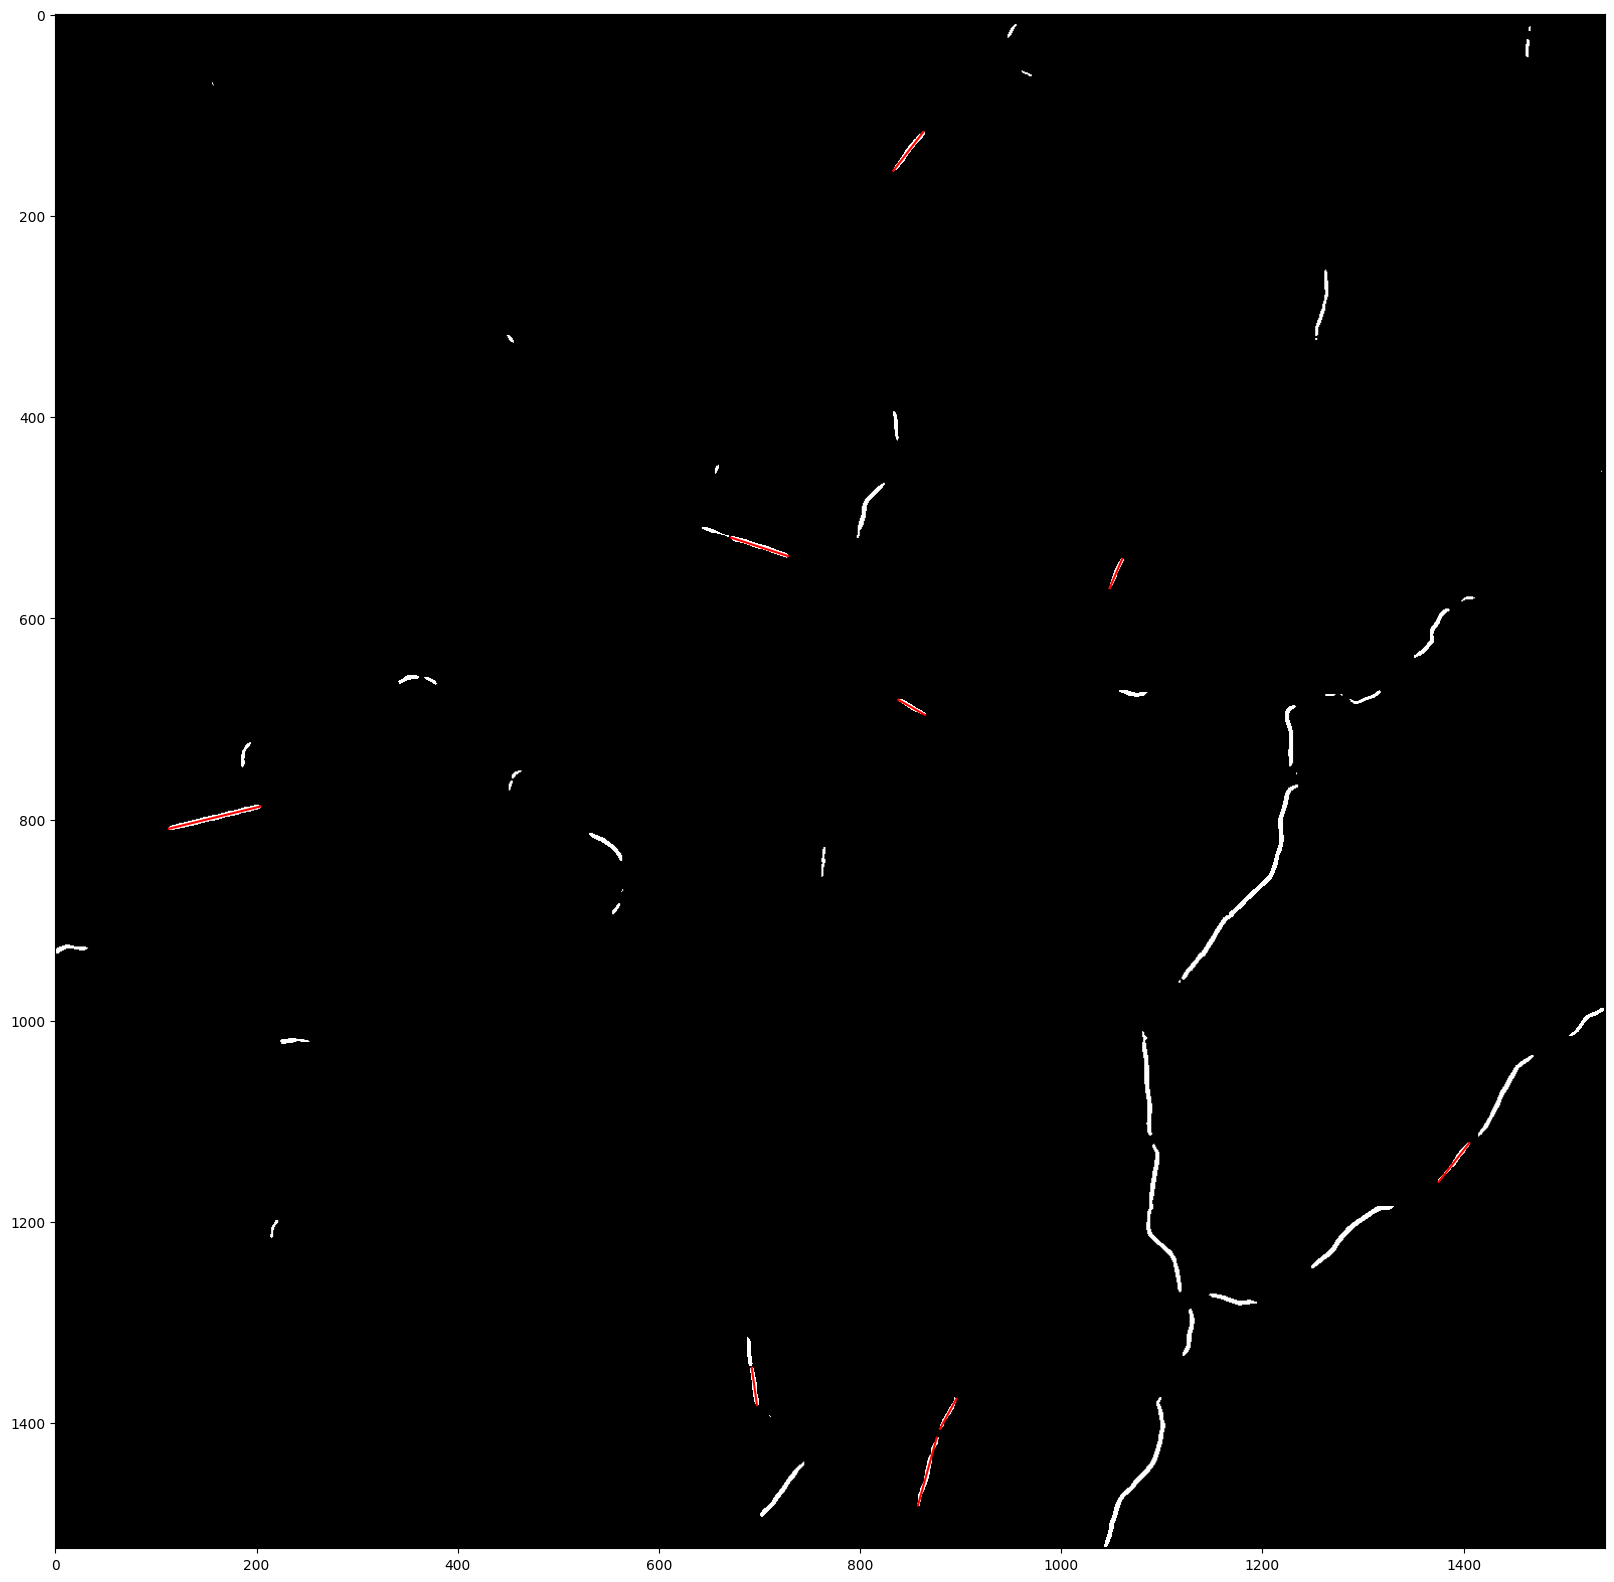

 Length: 49.02463240604533, Width: 5.563542487074187, Ratio: 8.811765618748227
 Endpoints: (array([116.26914579, 863.05561073]), array([155.03976515, 833.05138341]))
 Length: 59.43732738908625, Width: 5.429306782985179, Ratio: 10.947498412754271
 Endpoints: (array([519.72898949, 671.76413758]), array([538.02590921, 728.31516423]))
 Length: 31.777151792037245, Width: 4.307405287578831, Ratio: 7.377330357947118
 Endpoints: (array([ 540.86908089, 1060.69621639]), array([ 570.05157645, 1048.11967755]))
 Length: 30.39017062733933, Width: 4.476561408669568, Ratio: 6.788730870190671
 Endpoints: (array([680.90971224, 838.05143006]), array([695.95151876, 864.45799226]))
 Length: 93.85723194770083, Width: 5.5635085242888636, Ratio: 16.870151548783294
 Endpoints: (array([809.11417465, 112.78518046]), array([786.99421148, 203.99859624]))
 Length: 49.03487484218506, Width: 4.921693678212705, Ratio: 9.963008274824592
 Endpoints: (array([1121.72690182, 1405.65440352]), array([1160.1995114 , 1375.2524

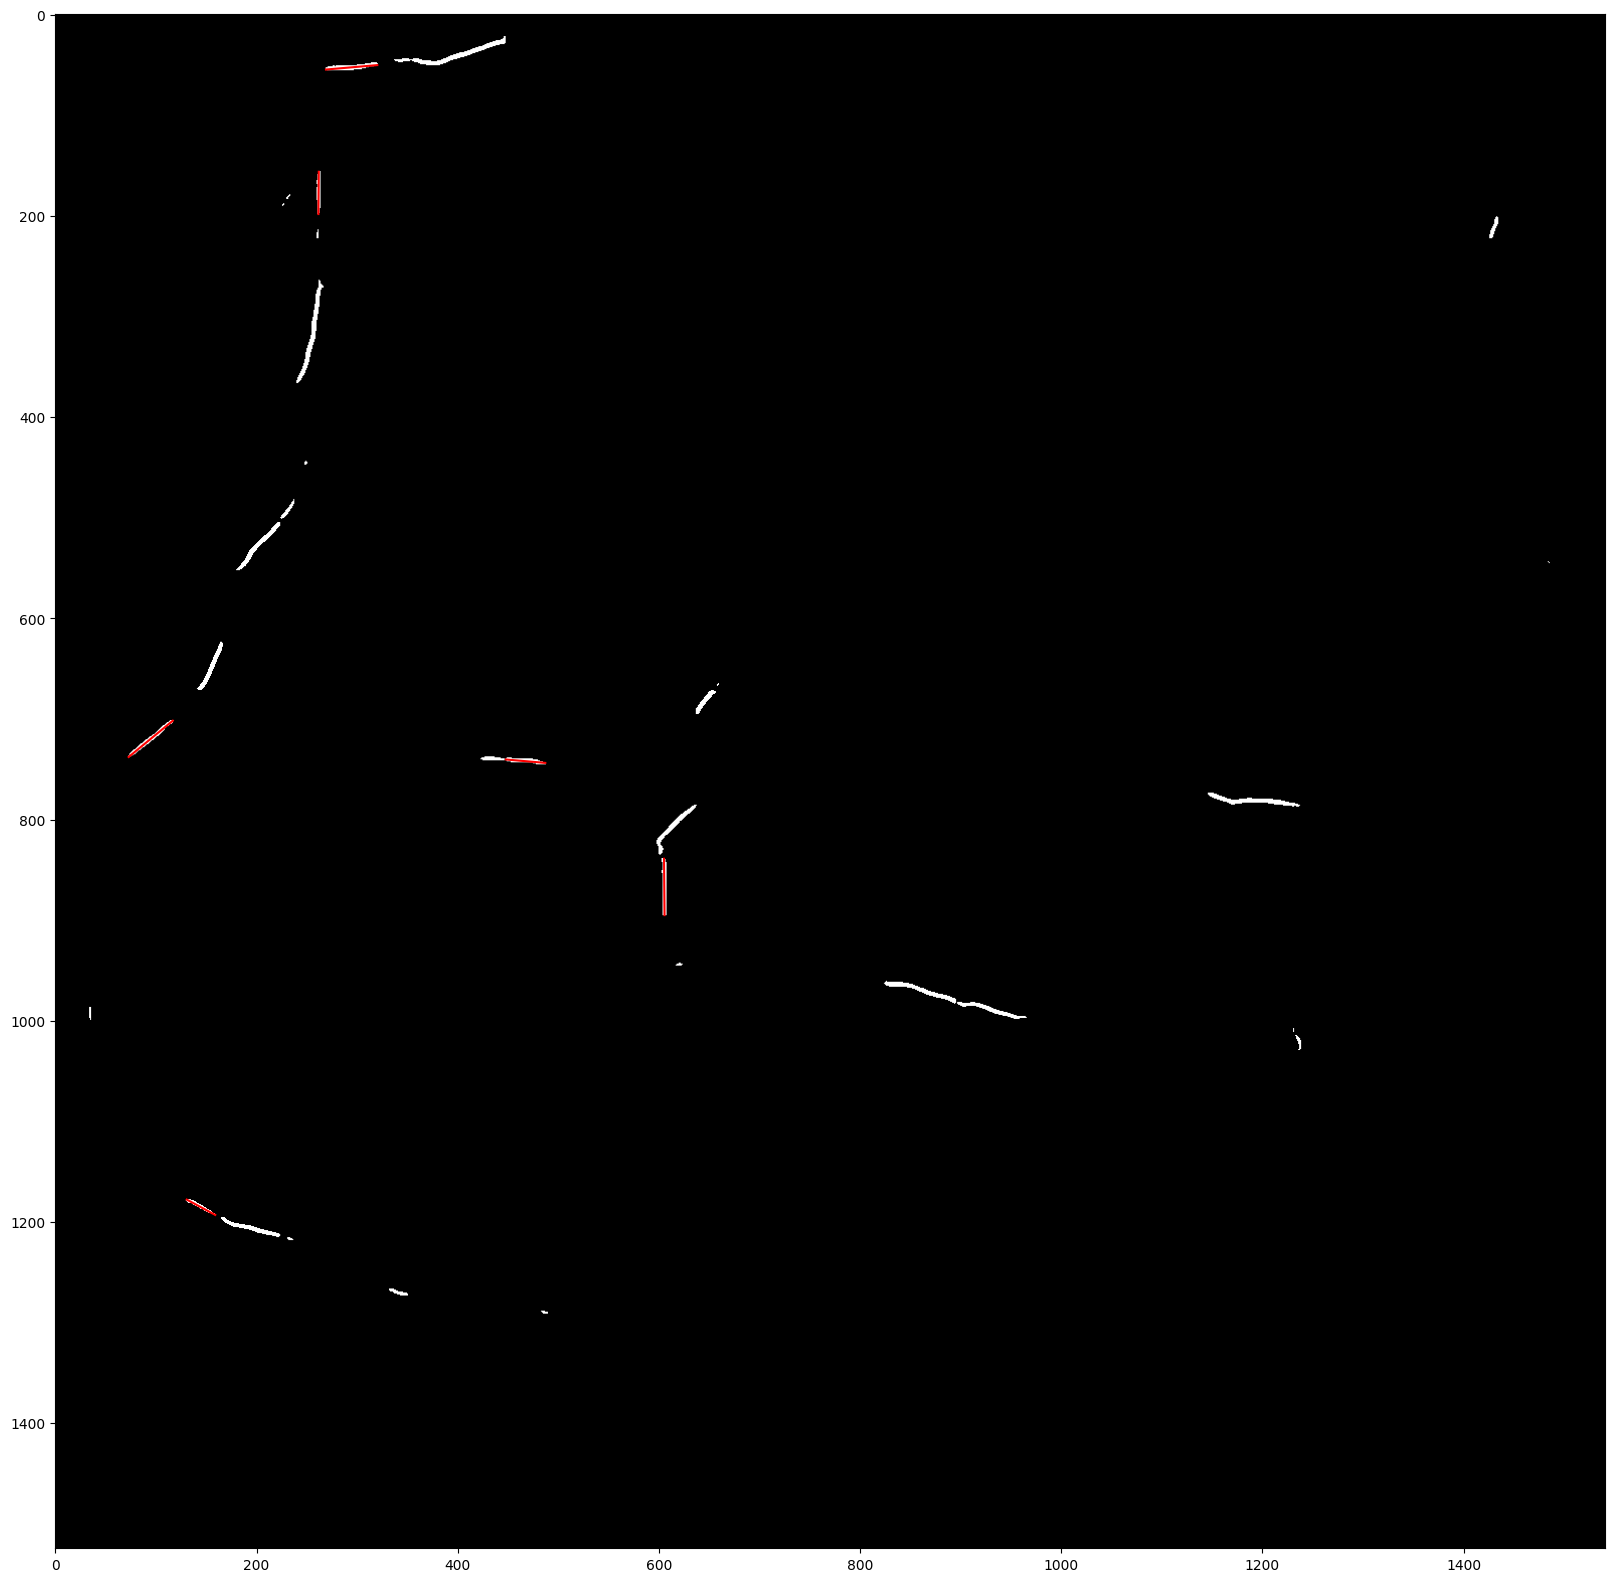

 Length: 51.240960013976405, Width: 5.70217584089869, Ratio: 8.986211832762525
 Endpoints: (array([ 54.33451834, 269.02882385]), array([ 49.93562909, 320.08061869]))
 Length: 42.01543384187329, Width: 3.2285894049013564, Ratio: 13.013557492968665
 Endpoints: (array([155.99067909, 261.89961134]), array([198.0046057 , 261.54372968]))
 Length: 56.85059996340914, Width: 4.604262735114958, Ratio: 12.347383986111668
 Endpoints: (array([737.80576403,  72.84052933]), array([701.73129484, 116.779389  ]))
 Length: 39.285739330544686, Width: 4.797797794517805, Ratio: 8.188285753816983
 Endpoints: (array([740.28944474, 447.97497409]), array([743.67353475, 487.11468857]))
 Length: 56.03356529003838, Width: 4.089363159165259, Ratio: 13.70227174968638
 Endpoints: (array([838.98079228, 605.14546623]), array([895.01211213, 605.64709804]))
 Length: 32.17131705687427, Width: 4.198137125537755, Ratio: 7.663236358139047
 Endpoints: (array([1177.83058244,  130.62941259]), array([1193.07785638,  158.95809556

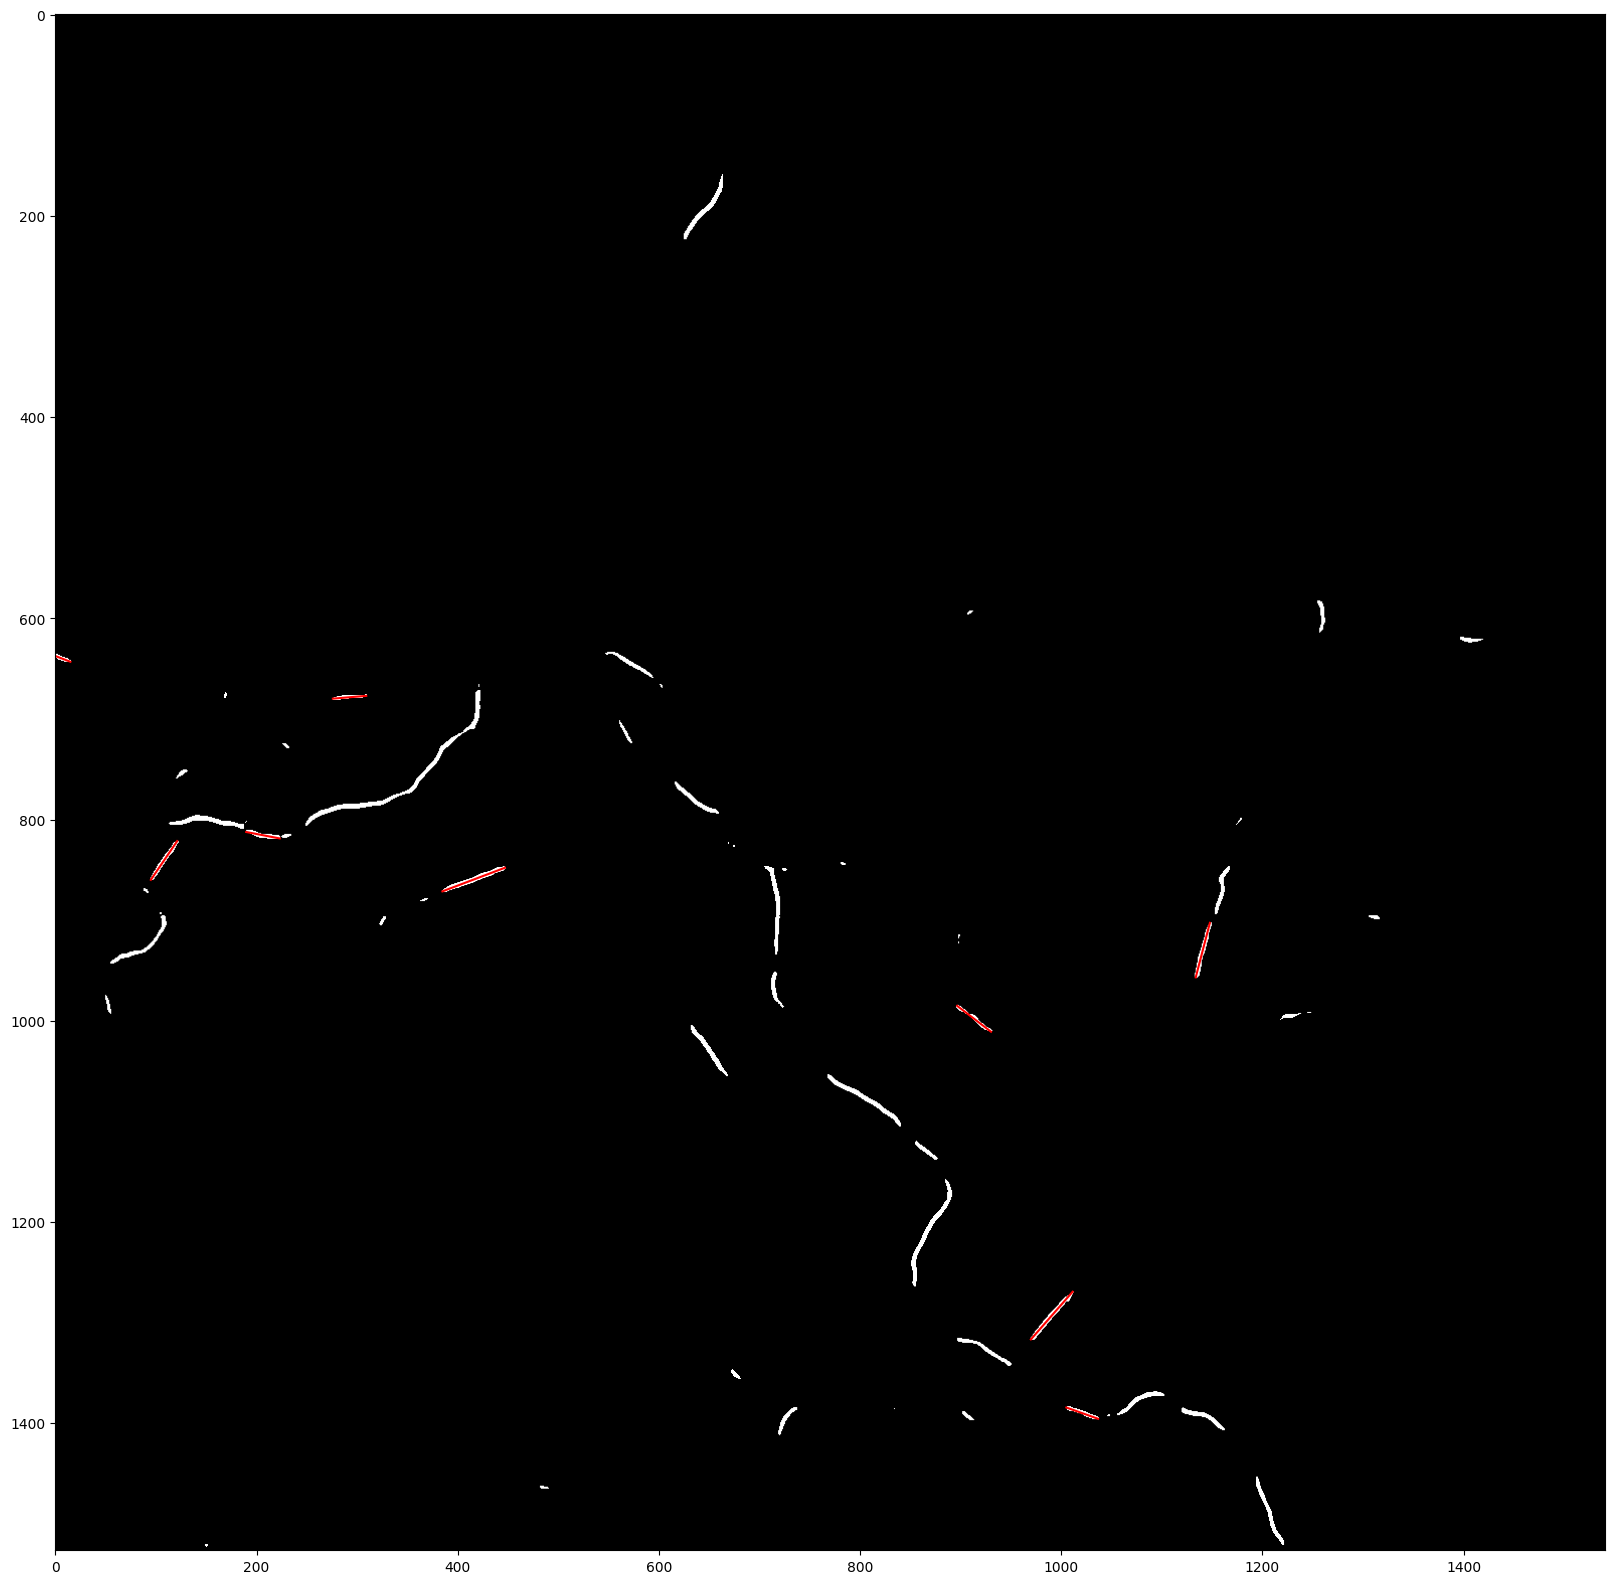

 Length: 16.153812171126503, Width: 4.310743887145236, Ratio: 3.7473374883851585
 Endpoints: (array([ 6.37365727e+02, -1.40203170e-01]), array([643.14803886,  14.94324861]))
 Length: 33.30179128677099, Width: 3.8195165198644645, Ratio: 8.718849915578506
 Endpoints: (array([679.81426044, 275.90089289]), array([677.04048455, 309.08696633]))
 Length: 33.91825483519506, Width: 5.566444375871129, Ratio: 6.093342993279614
 Endpoints: (array([812.38024533, 189.73344584]), array([818.81173237, 223.03635841]))
 Length: 46.60546708959862, Width: 5.096072402213622, Ratio: 9.14536988708289
 Endpoints: (array([821.41170721, 121.13464965]), array([859.95401517,  94.93235852]))
 Length: 66.48089049035005, Width: 5.591905400008159, Ratio: 11.888772383426417
 Endpoints: (array([871.41845105, 384.78029508]), array([847.92325657, 446.9710069 ]))
 Length: 56.03647231451282, Width: 5.489018735362379, Ratio: 10.20883240086324
 Endpoints: (array([ 902.69761054, 1147.83467509]), array([ 956.93770817, 1133.759

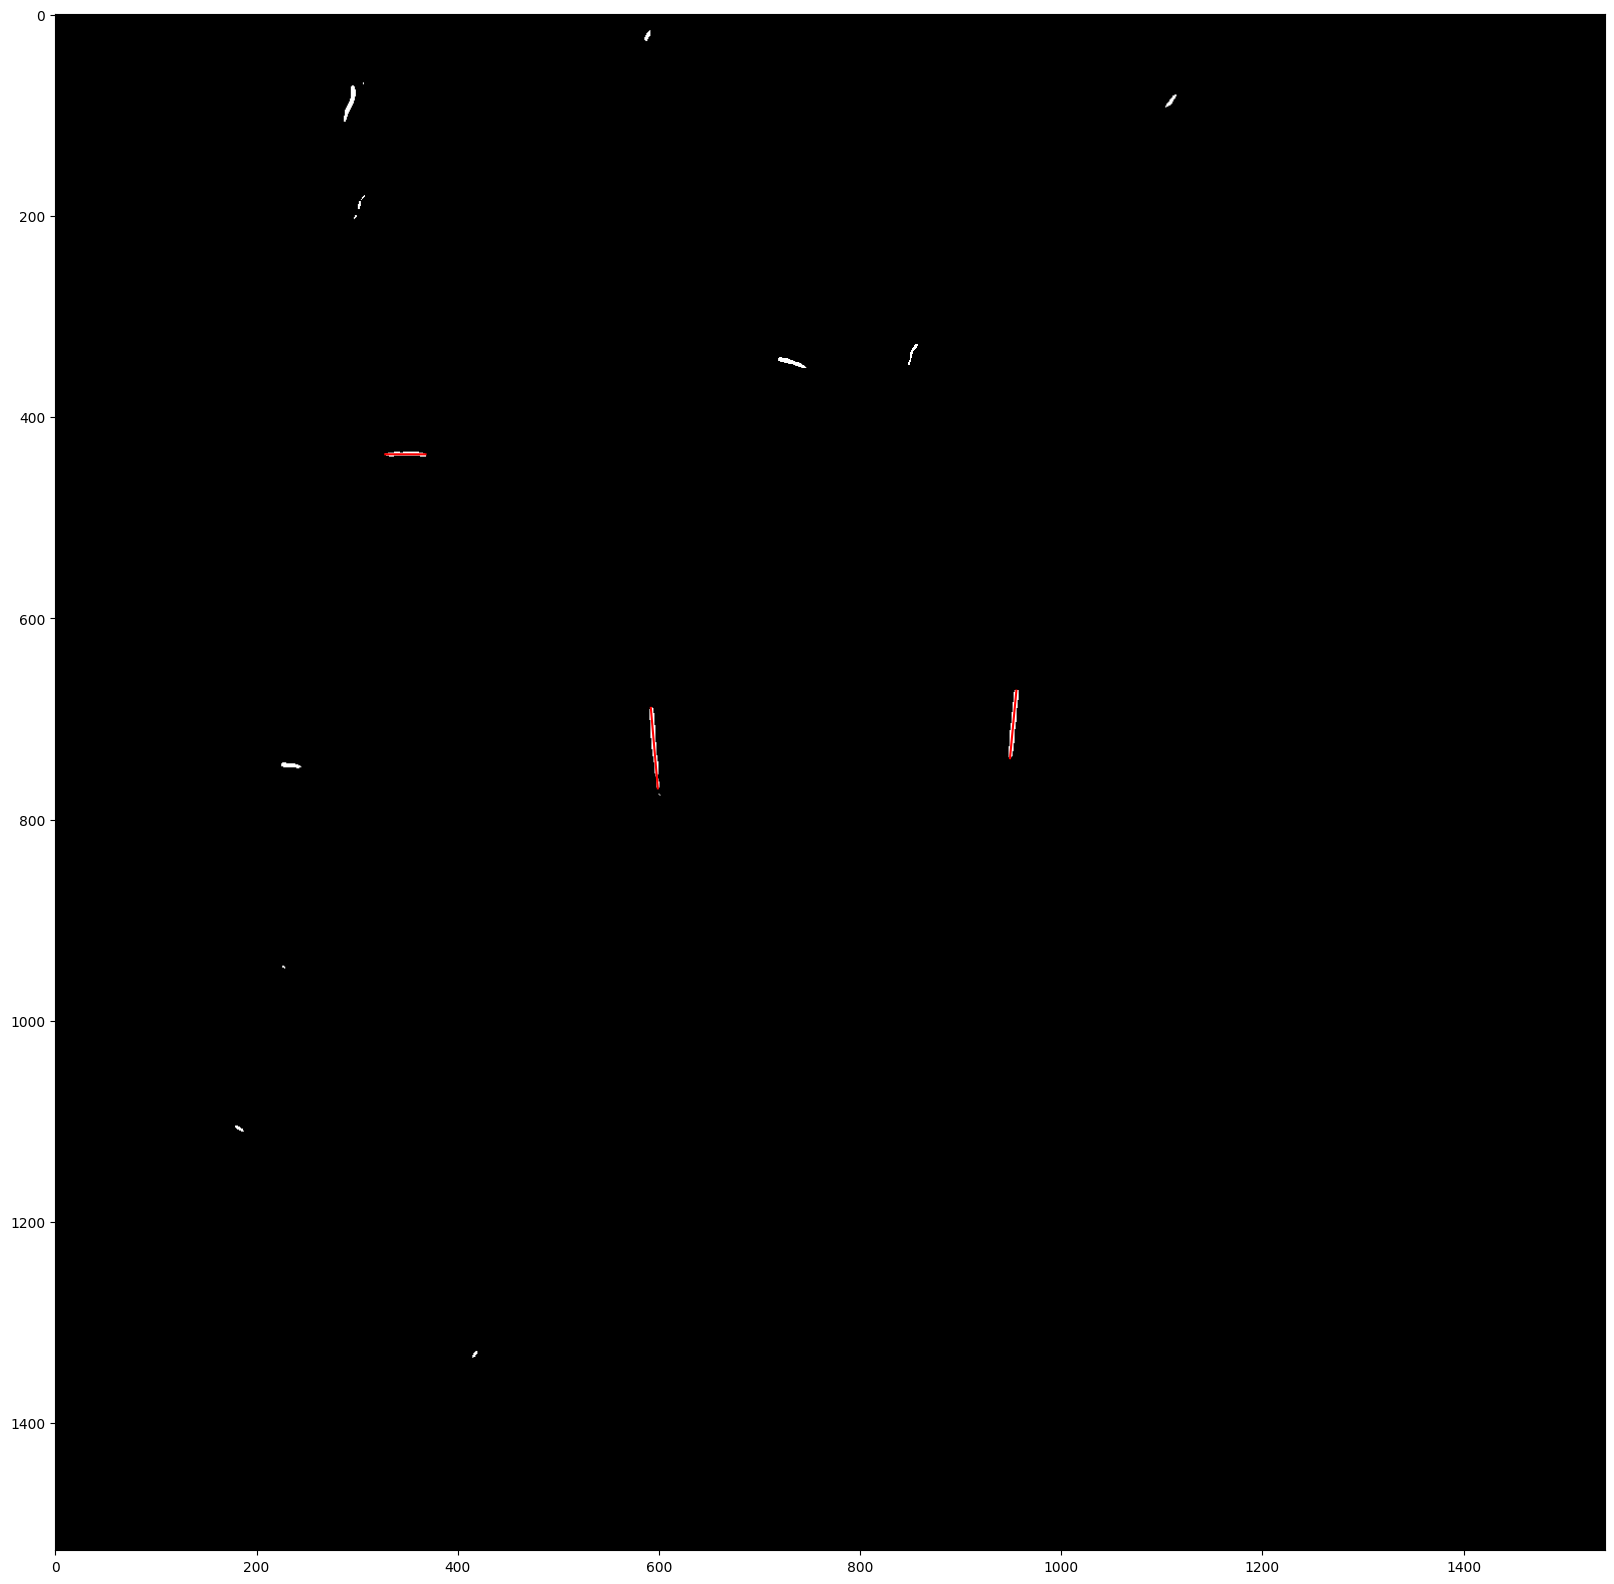

 Length: 40.0026415225791, Width: 4.038818193637439, Ratio: 9.904541280317432
 Endpoints: (array([436.85771048, 328.00019048]), array([436.91126129, 368.00279616]))
 Length: 67.45561330655119, Width: 5.125849997013802, Ratio: 13.159888281133709
 Endpoints: (array([671.8532105 , 955.44808051]), array([739.00908875, 949.09609004]))
 Length: 80.30564075009625, Width: 5.0618150612253885, Ratio: 15.864989095562782
 Endpoints: (array([688.99671261, 592.03791682]), array([769.00221885, 598.97440778]))
Number of pixels with background or signal:11731
Processing aoi_2022_01
Skipping cluster with 1.0 points - insufficient for PCA.


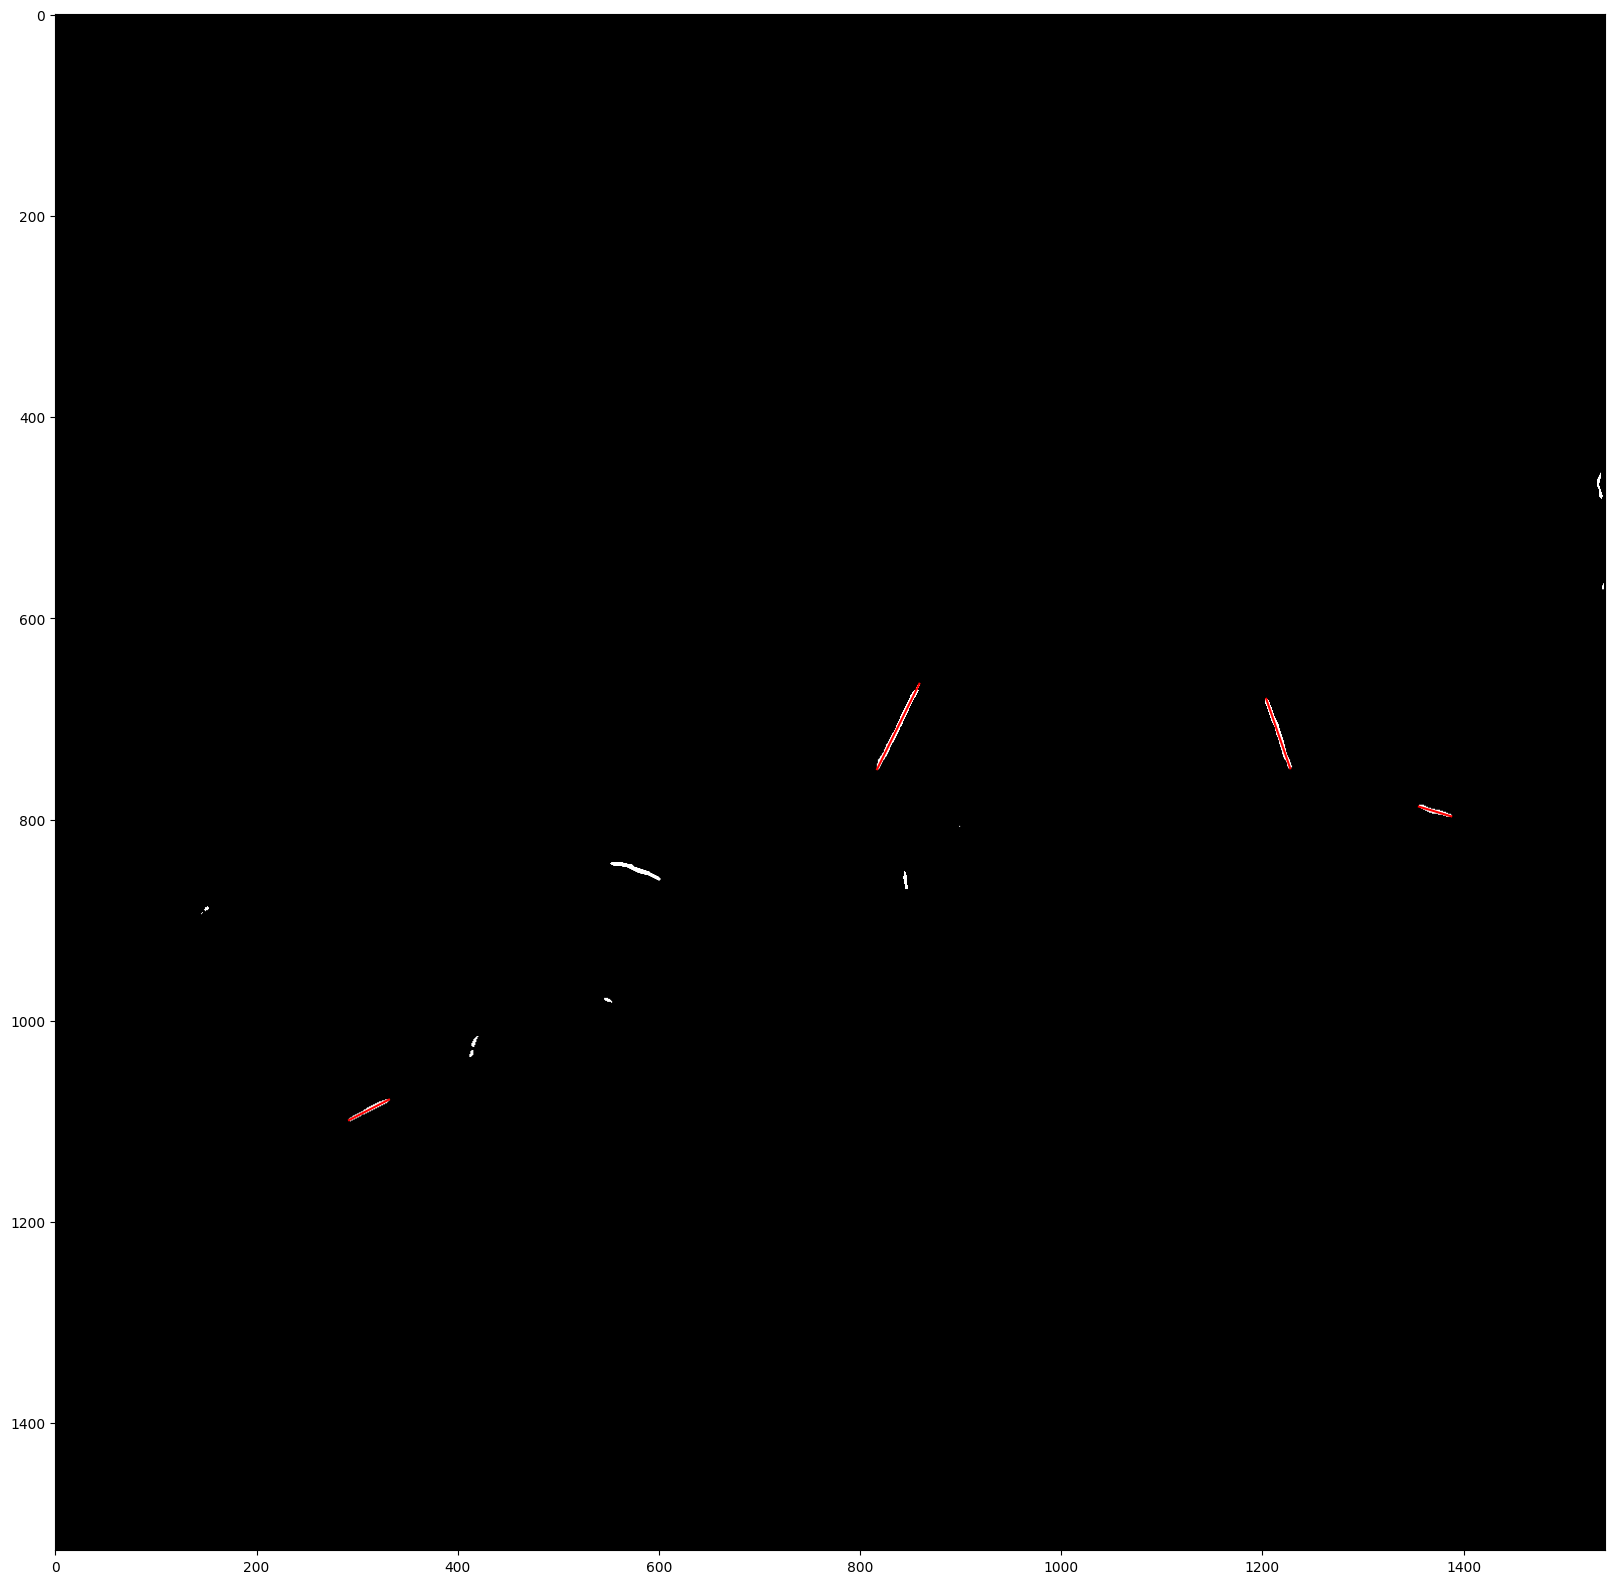

 Length: 94.81027972289871, Width: 5.521850947663097, Ratio: 17.170017919991732
 Endpoints: (array([664.99780124, 858.99556242]), array([749.95153646, 816.90218985]))
 Length: 73.05454961207101, Width: 5.71118194333792, Ratio: 12.79149400892209
 Endpoints: (array([ 680.04610614, 1203.86637849]), array([ 749.1051625 , 1227.69522557]))
 Length: 33.52377229184549, Width: 5.0806194474208155, Ratio: 6.59836317968351
 Endpoints: (array([ 787.16150531, 1355.65202843]), array([ 796.78231381, 1387.76562917]))
 Length: 44.71900278404348, Width: 4.222131300939964, Ratio: 10.591570843400296
 Endpoints: (array([1098.82330247,  291.9093719 ]), array([1078.41478374,  331.69984279]))
Number of pixels with background or signal:15517
Processing aoi_2022_02


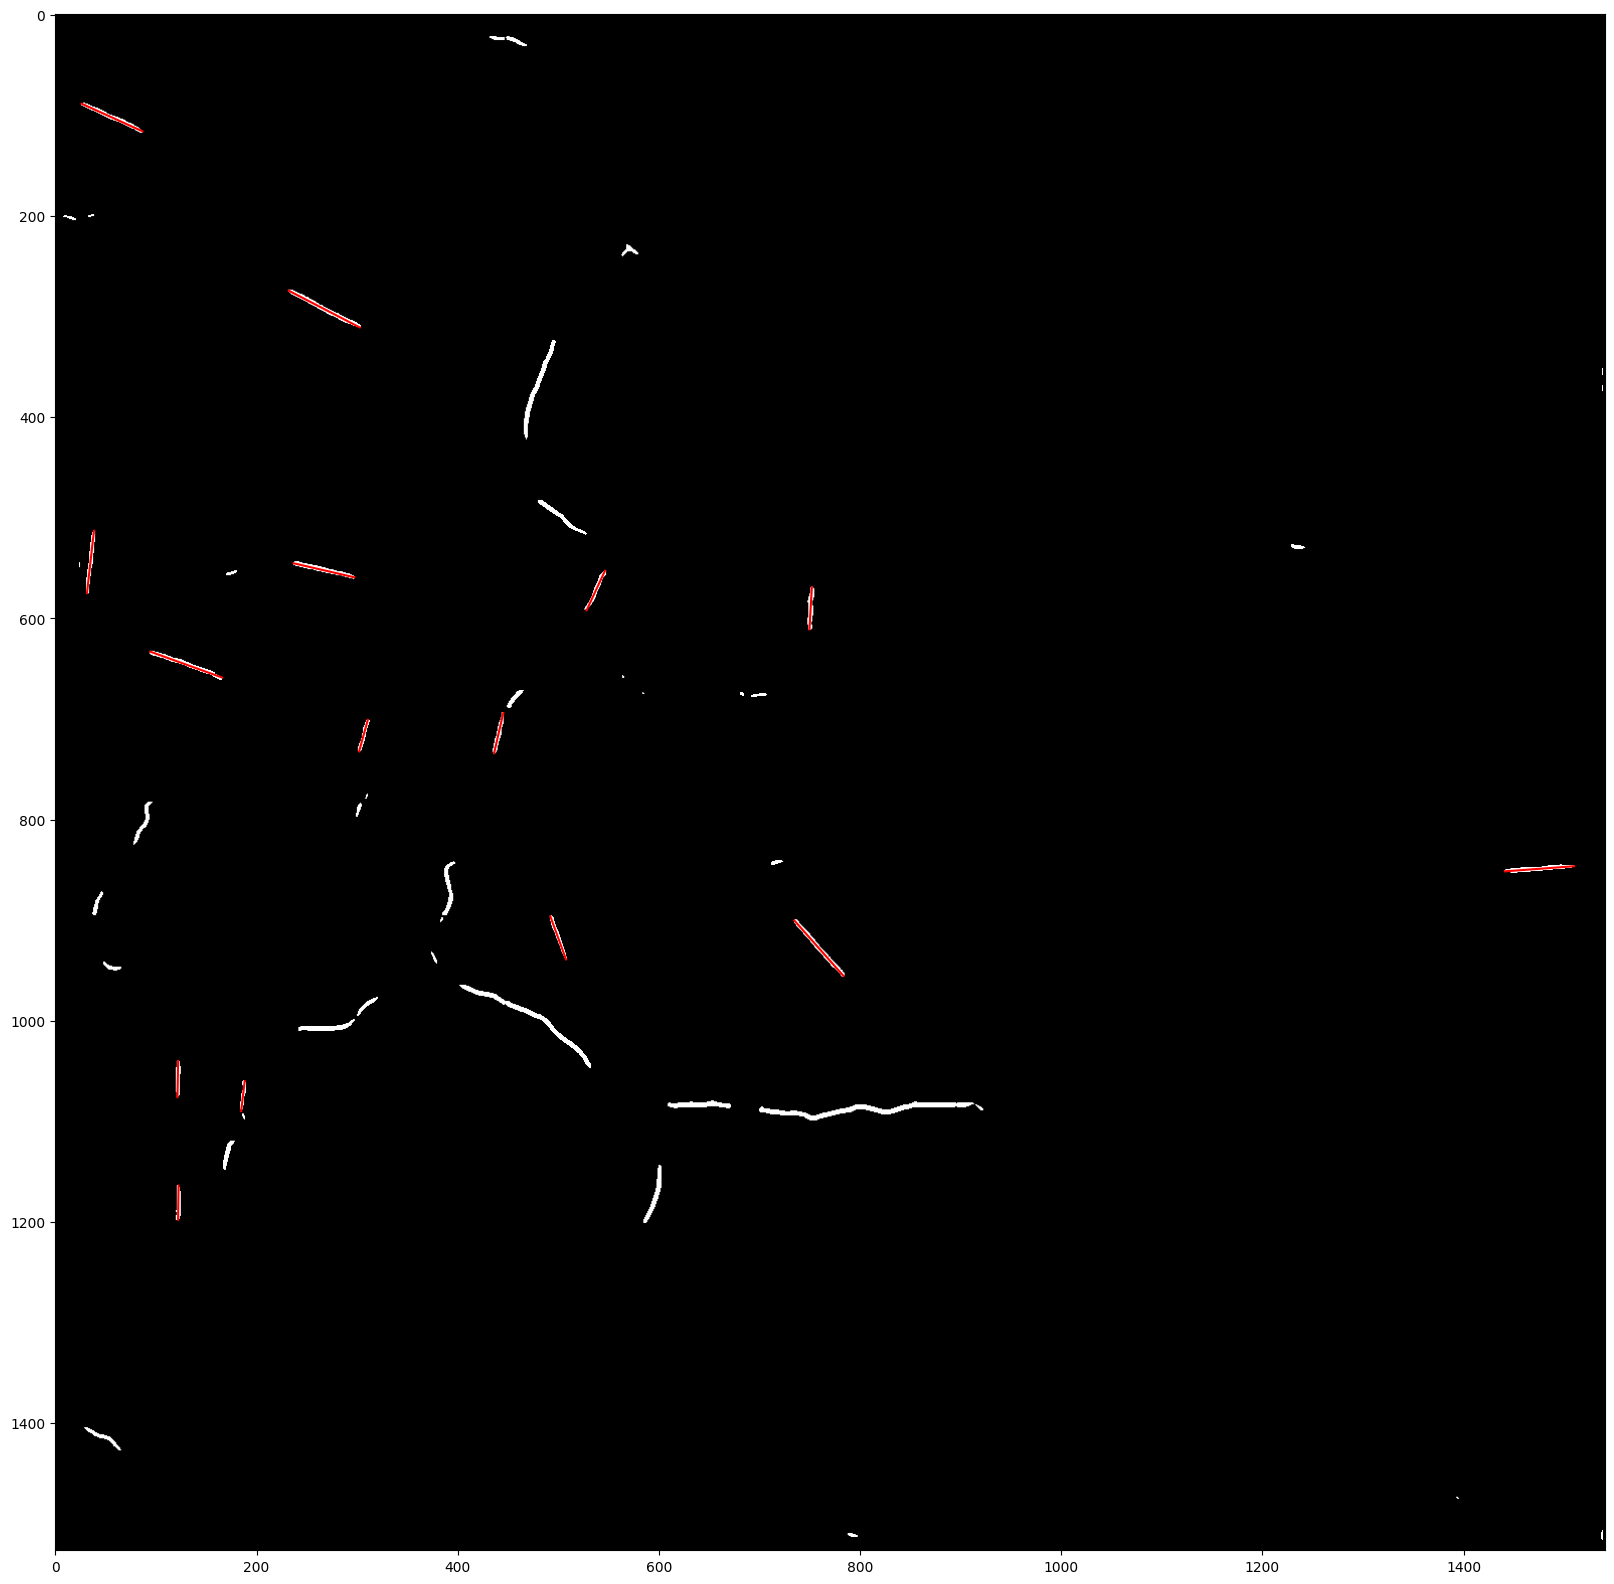

 Length: 66.20830459010739, Width: 4.962921660691649, Ratio: 13.340590304800497
 Endpoints: (array([88.36944533, 26.2864268 ]), array([115.75166441,  86.56705117]))
 Length: 79.6024237035013, Width: 5.473100676611153, Ratio: 14.544301010883233
 Endpoints: (array([274.15798494, 231.91820639]), array([310.75643488, 302.60837063]))
 Length: 62.393898709673635, Width: 4.400211557071799, Ratio: 14.179749746213291
 Endpoints: (array([512.93164605,  38.39130073]), array([574.93582717,  31.42853412]))
 Length: 61.83671567760746, Width: 4.949460637085679, Ratio: 12.493627126615134
 Endpoints: (array([545.24060741, 236.94439532]), array([559.16417345, 297.19316057]))
 Length: 43.31393109137798, Width: 5.244545636514886, Ratio: 8.258852928994823
 Endpoints: (array([552.73458249, 546.43043675]), array([591.9949334 , 528.13504189]))
 Length: 42.10282362087264, Width: 5.792349474425464, Ratio: 7.268695338008549
 Endpoints: (array([569.00704192, 752.12295046]), array([611.04097873, 749.71548015]))
 L

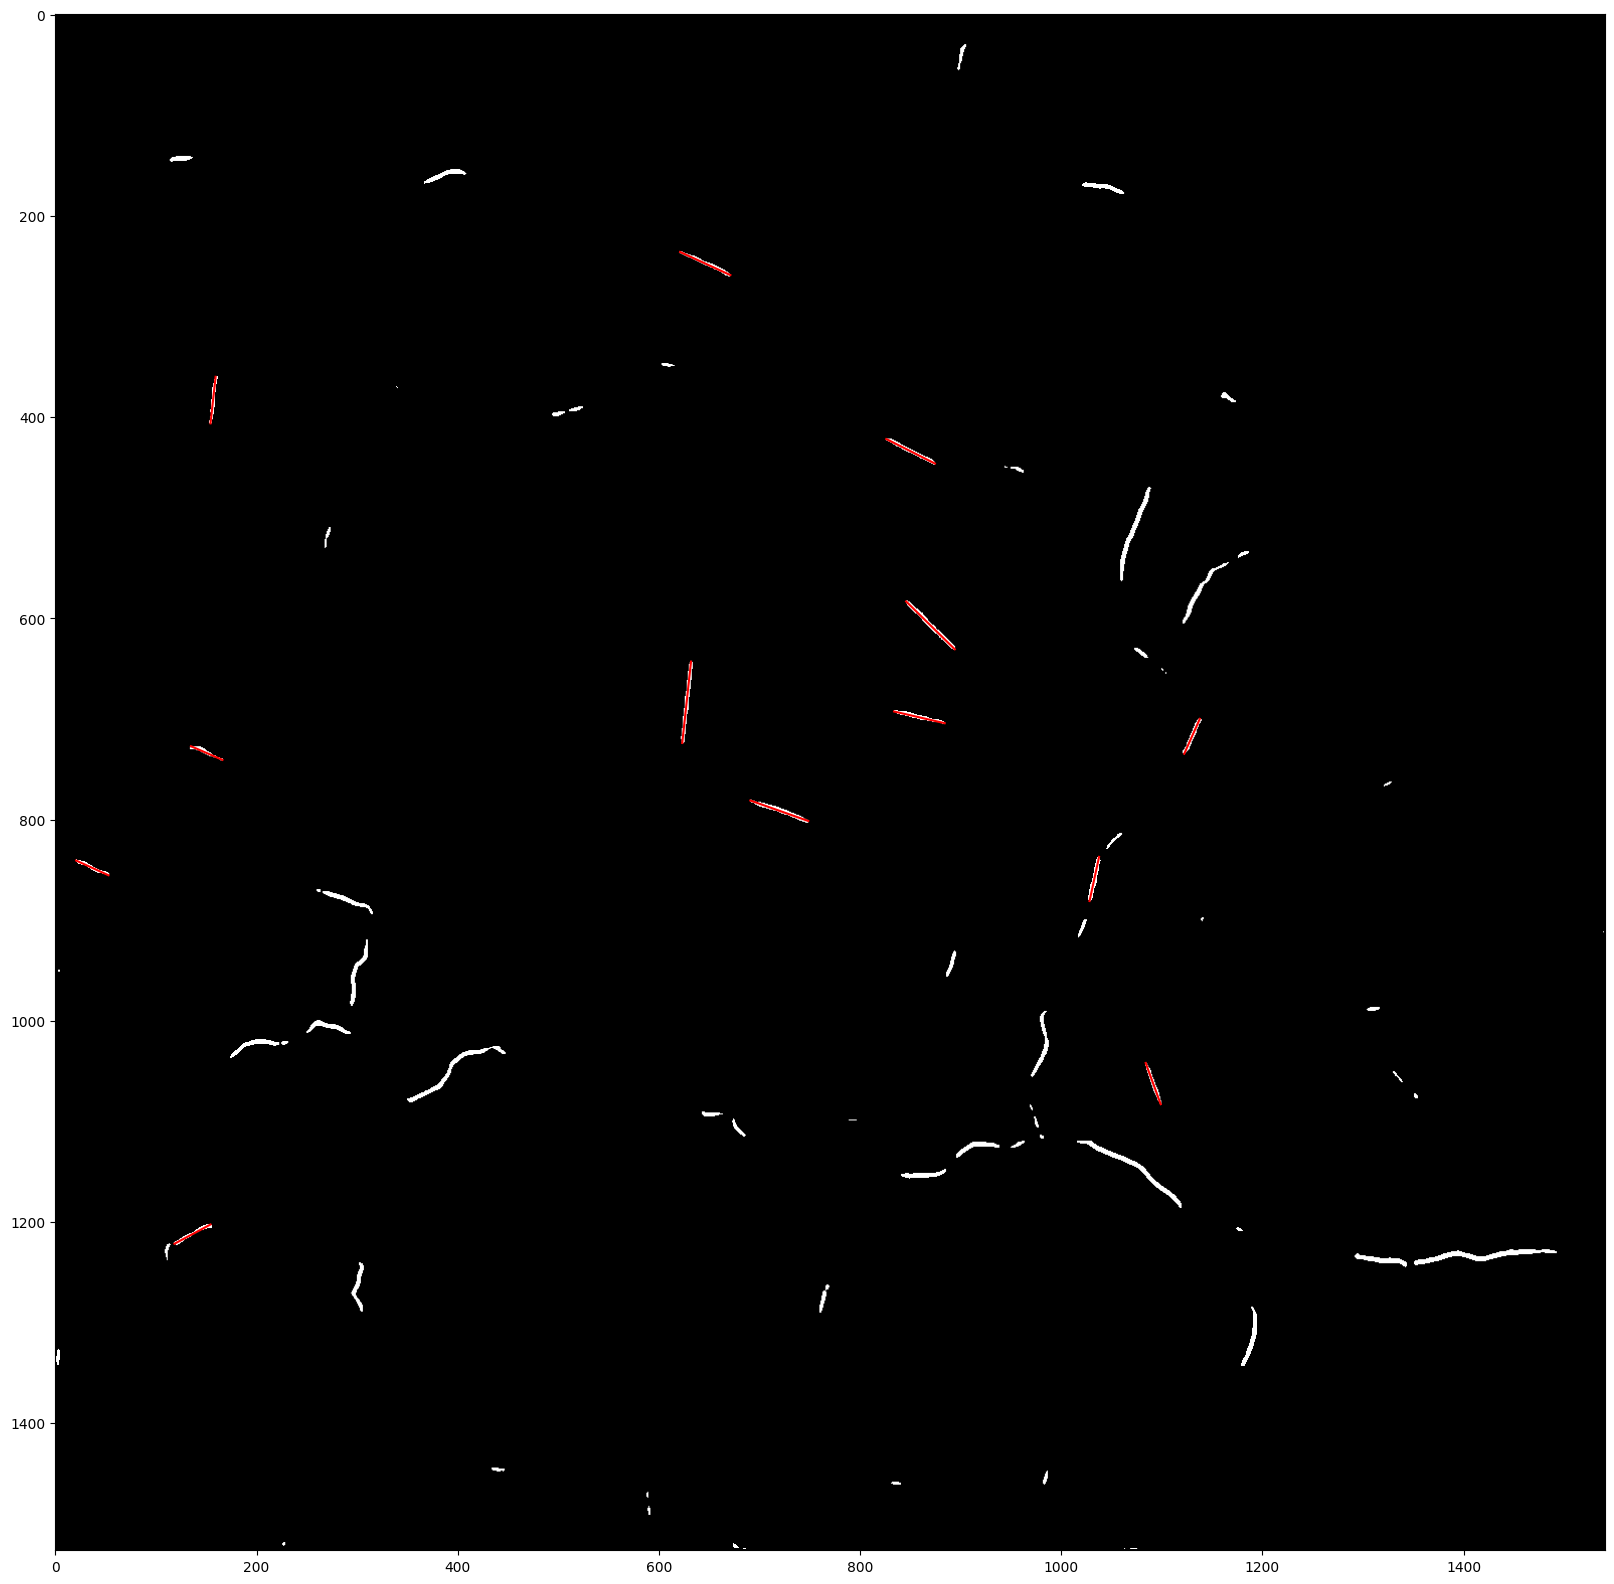

 Length: 55.03634777871537, Width: 4.554489061285814, Ratio: 12.083978474454304
 Endpoints: (array([235.7130988, 621.1321045]), array([258.73178446, 671.12350064]))
 Length: 46.59855909300478, Width: 4.063147848632383, Ratio: 11.468585645656338
 Endpoints: (array([359.81780206, 159.34175082]), array([406.13760836, 154.25242332]))
 Length: 54.11520666072499, Width: 4.132313894900321, Ratio: 13.095618589746643
 Endpoints: (array([421.71612473, 826.14296592]), array([446.05713803, 874.47484632]))
 Length: 67.87975983167576, Width: 5.222169314620828, Ratio: 12.998383572441556
 Endpoints: (array([583.16977857, 845.83310585]), array([630.75504983, 894.24078865]))
 Length: 81.3907129746699, Width: 4.378412178905819, Ratio: 18.589093408517268
 Endpoints: (array([642.99692759, 631.97154907]), array([723.91716991, 623.23298277]))
 Length: 51.64274146176058, Width: 4.647008750619932, Ratio: 11.113114743946028
 Endpoints: (array([692.59741157, 833.86213222]), array([704.21005883, 884.18229884]))
 

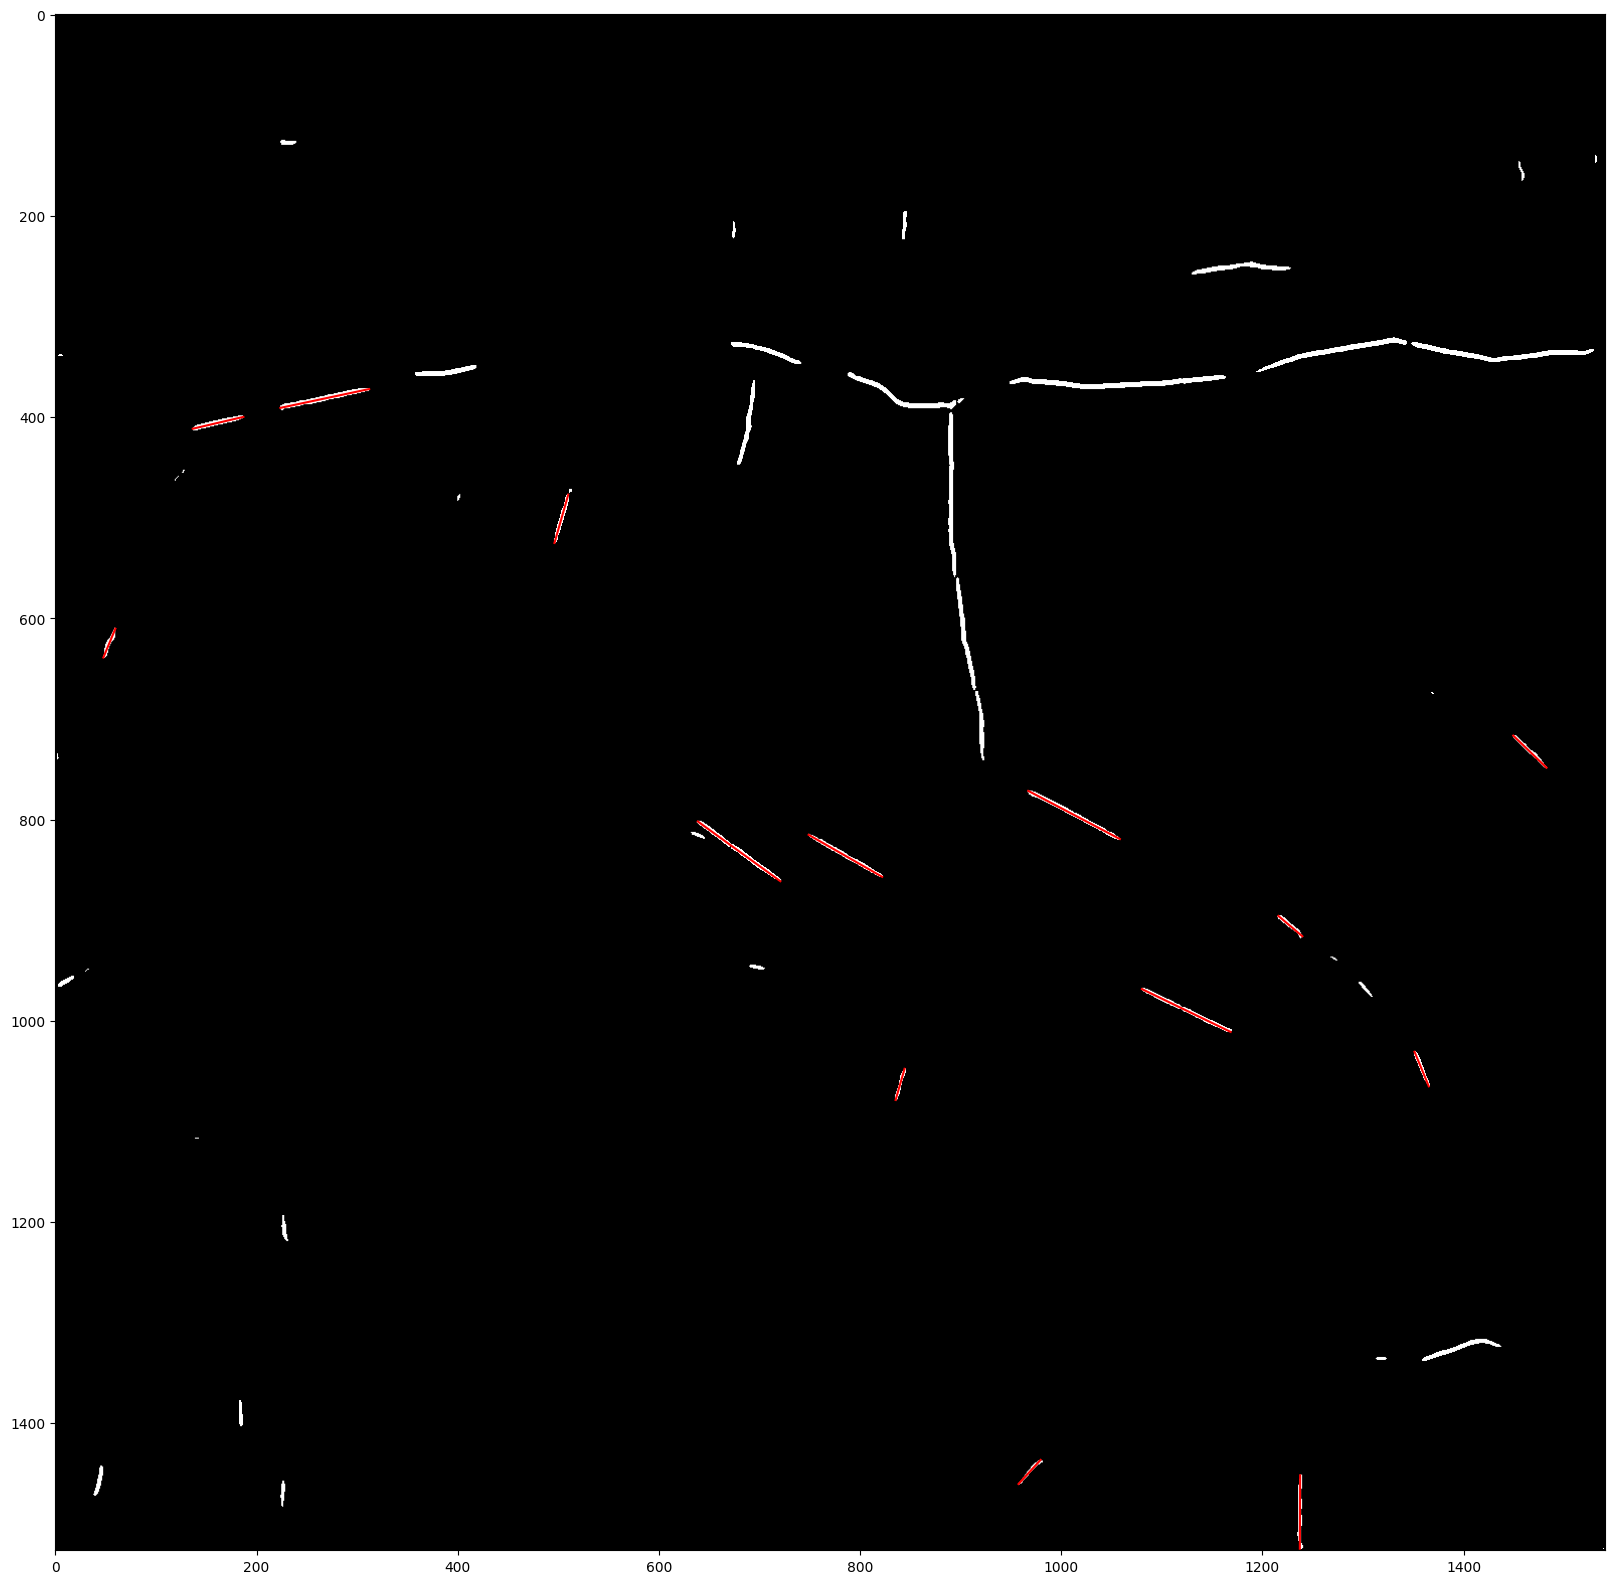

 Length: 90.23434912431051, Width: 5.595828187513121, Ratio: 16.125289430019503
 Endpoints: (array([390.7135729 , 223.72746686]), array([372.01224274, 312.00259366]))
 Length: 51.64600980226254, Width: 5.12938123219044, Ratio: 10.068662761533078
 Endpoints: (array([411.4412543 , 136.63633782]), array([399.70713294, 186.93167284]))
 Length: 49.999181188052546, Width: 4.536759681868261, Ratio: 11.020901412935899
 Endpoints: (array([476.98193973, 509.93673432]), array([525.06048768, 496.21189017]))
 Length: 31.00013292327924, Width: 5.616706302317539, Ratio: 5.519272551332818
 Endpoints: (array([610.27989932,  59.67201047]), array([638.89699452,  47.75269406]))
 Length: 45.967149171775645, Width: 4.189444419810513, Ratio: 10.97213486218173
 Endpoints: (array([ 716.54697257, 1449.43652375]), array([ 748.44213155, 1482.53754543]))
 Length: 102.88332058922265, Width: 5.6620873778741725, Ratio: 18.170563914513473
 Endpoints: (array([771.50613676, 967.25958281]), array([ 819.3738203 , 1058.329

In [64]:
aoi_files = ['aoi_2020_01', 'aoi_2020_02', 'aoi_2020_03', 'aoi_2021_01', 'aoi_2021_02', 'aoi_2021_03', 'aoi_2021_04', 'aoi_2022_01', 'aoi_2022_02', 'aoi_2023_01', 'aoi_2024_01']
aoi_directory = '/content/drive/MyDrive/Zindi-Amazon/Studies/model_20241030_20m_lr0005_B4_B3_B2_B8_VV'

for aoi_file in aoi_files:
    print(f'Processing {aoi_file}')
    geotiff_path = f'{aoi_directory}/{aoi_file}_prediction_mosaic.tif'

    binary_mask = load_binary_mask_from_geotiff(geotiff_path)
    lines = process_clusters(binary_mask)

    plot_clusters_and_lines(binary_mask, lines)

    # Output the line information
    for line in lines:
        print(f" Length: {line['length']}, Width: {line['width']}, Ratio: {line['ratio']}")
        print(f" Endpoints: {line['endpoints']}")

    # Convert lines to GeoJSON object.
    geojson_data = lines_to_geojson(lines, geotiff_path)

    # Get model bands stored in name of the directory.
    bands = extract_model_bands(aoi_directory)

    # Create final mask with padding.
    create_mask_from_geojson(geojson_data, geotiff_path, f'{aoi_file}_{bands}_prediction_final.tif')

    submission_tag = modify_string_for_submission_file(aoi_file)
    df = create_dataframe_from_mask(f'{aoi_file}_{bands}_prediction_final.tif', submission_tag)
    print(f'Number of pixels with background or signal:{len(df)}')

    csv_path = f'output_file_{bands}.csv'  # Path to your CSV file
    export_dataframe_to_csv(df, csv_path)
